### preload functions

In [31]:
import numpy as np


def IQR(data):
    
    if np.__version__ != '1.19.5':
        # First quartile (Q1)
        Q1 = np.percentile(data, 25, method = 'midpoint') # or method in later version

        # Third quartile (Q3)
        Q3 = np.percentile(data, 75, method = 'midpoint')
    else : 
        # First quartile (Q1)
        Q1 = np.percentile(data, 25, interpolation = 'midpoint') # or method in later version

        # Third quartile (Q3)
        Q3 = np.percentile(data, 75, interpolation = 'midpoint')

    # Interquaritle range (IQR)
    iqr = Q3 - Q1
    return [Q1, Q3]

def getDate(d, m, y):
    date = ''
    if d == 0 :
        d =1 # days start counting from 1
    if d == d and m == m and y == y:
        if len(str(int(d))) < 2:
            date += '0' 
        date += str(int(d)) + '-'
        if len(str(int(m))) < 2:
            date += '0' 
        date += str(int(m)) + '-'
        date += str(int(y))
        if y > 2030:
            print('Impossible Date found (added np.nan):', date)
            return np.nan
        if d > 31:
            print('Impossible Date found (added np.nan):', date)
            return np.nan
        if m > 12:
            print('Impossible Date found (added np.nan):', date)
            return np.nan
        else :
            return date
    else : 
        return np.nan

### import data 

#### source of data
\\vf-reuma-research\reuma-research$\Improved\Basis SPSS bestanden\Samenvoegen bestanden\Inclusie_basisdocument.SAV

In [ ]:
import numpy as np
import pandas as pd

file_path = '/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Inclusie_basisdocument.SAV'


# Read the Stata file into a pandas DataFrame
df = pd.read_spss(file_path)


d_map = {
    'IDNUM' : 'PATNR',
    #'TIME_STA' : 
    'LEEFTIJD' : 'Age',
    'GESLACHT' : 'Sex',
    'KLACHTDUUR' : 'symptomDuration',
    'LABRFPN' : 'RF',
    'ACPApn' : 'aCCP',
    
    'LABHB1' : 'Hb',
    'LABHEMAT' : 'Ht',
    'LABMCV' : 'MCV',
    'LABLEUC1' : 'Leuko',
    'LABTHROM' : 'Trom',
    'LABBSE' : 'BSE',
    
    'LABLYMF1' : 'Lym',
    'LABCRP' : 'CRP',
    'GPTOT' : 'TJC',
    'GZTOT' : 'SJC'
    
    
}

l_num = ['PATNR', 'Age', 'BSE', 'Hb', 'MCV', 'Trom', 'Leuko'] # no 'Ht', 
l_essential = ['PATNR', 'Age', 'Sex', 'aCCP', 'RF', 'BSE', 'Hb', 'MCV', 'Trom', 'Leuko', 'SJC', 'TJC', 'FirstConsult'] # no 'Ht',  

df = df.rename(columns= {'BSE' : 'bezinking'})
df = df.rename(columns= d_map)

df = df[df['EVALNUM']==1]
df['RF'] = df['RF'].replace(9, np.nan)
df['RF'] = df['RF'].replace({'Pos.' : 1, 'Neg.' : 0})
df['Sex'] = df['Sex']-1

# Select only those with RA diagnosis
df = df[df['DIAGNOSE']=='Ja'].copy()
df = df.reset_index(drop=True)

# Get first consult
df['FirstConsult'] = df.apply(lambda x : getDate(x['DATARTSD'], x['DATARTSM'], x['DATARTSY']), axis =1 )

df['FirstConsult'] = pd.to_datetime(df['FirstConsult'], format='%d-%m-%Y')
df['FirstConsult']


df


<AxesSubplot:>

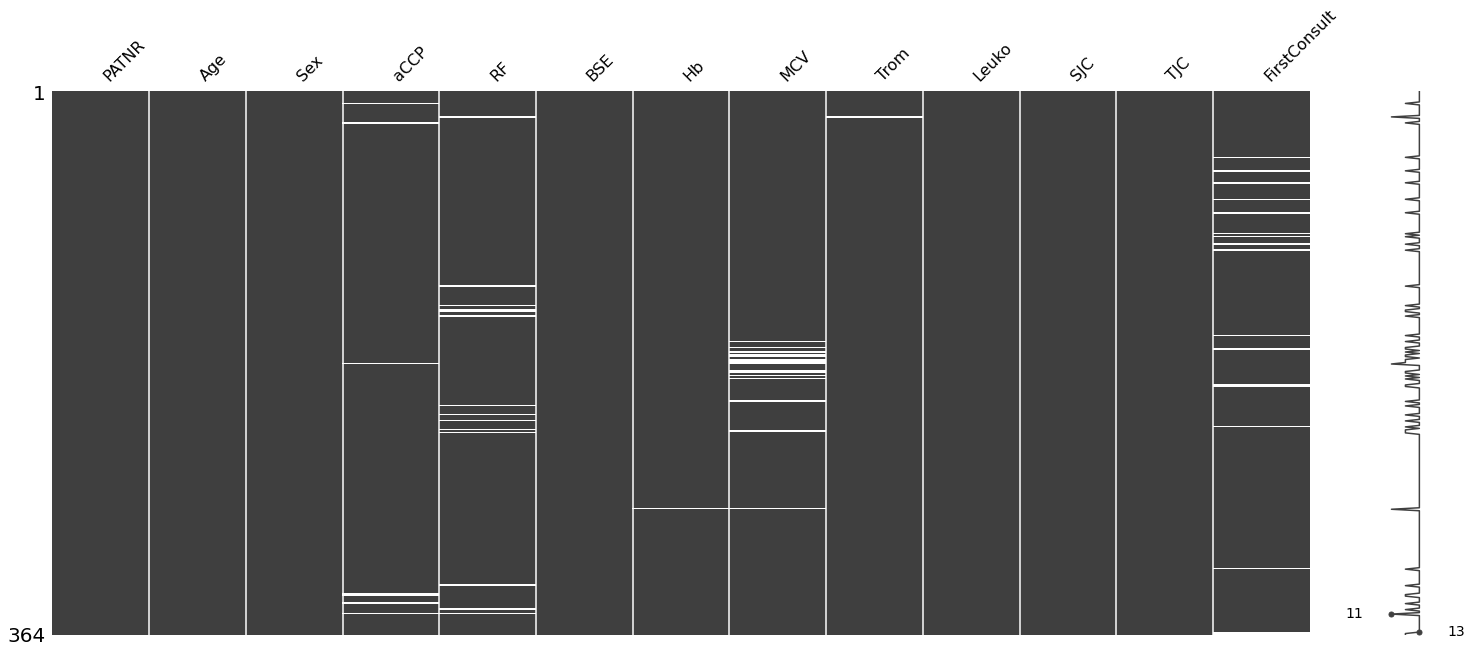

In [4]:
import missingno as msno
    
%matplotlib inline

# df_new[((~df_new['Anti-CCP'].isna()) & (~df_new['IgM reumafactor'].isna()))][l_keep].dropna(thresh=7)
msno.matrix(df[l_essential]) # check if patients that miss variables across lines -> have aCCP / RF of 2

## Preprocess categoric

In [ ]:
import re 

def convert_EAC_name_Mannequin(col_name):
    """
    Standardize the data by converting the name of a METEOR variable to the HIX equivalent
    
    Input:
        col_name = initial column name
    Return: 
        new_col = updated column name
    """
    new_col = ""
    d_swollen = {'GZ' : 'Zwelling_', 'GP': 'Pijn_'}
    d_side = {'L': 'links', 'R' : 'rechts'} # 
    d_side_alt = {'L': 'L', 'R' : 'R'}
    
    d_entity = {'ACC': 'acromioclaviaculair', 'ENK': 'bovenste spronggewricht', 'STAL': 'onderste spronggewricht', 'ELB' : 'Elleboog', 'IP' : 'IP', 'KNIE' : 'knie', 'MCP' : 'mcp', 'MTAR' : 'tarsometatarsaal', 'MTP' : 'mtp', 'PIP' : 'pip', 'STEC' : 'sternoclaviculair', 'SCH' : 'schouder', 'KAA' : 'temporomandibulair', 'POL' : 'pols','PIP' : 'pip', 'DIP' : 'dip', 
                'HEUP' : 'heup'} # Or is it PIP
    if col_name[0:2] in d_swollen and col_name[-1] in d_side:
        # extract specific joint
        joint = re.search("^(" + "|".join(d_entity.keys())+ ")$", ''.join([i for i in col_name[2:-1] if not i.isdigit()]))
        if joint and '28' not in col_name:
            new_col += d_swollen[col_name[0:2]]
            
            # Account for exceptions
            if joint[0] == 'ELB' and col_name[-1]=='R' :
                entity = d_entity[joint[0]].lower()
            elif  joint[0] == 'ENK' and col_name[-1]=='L':
                entity = 'bovenste spronggewicht' 
            elif joint[0] == 'VIP' :
                if col_name[-2].isdigit():
                    entity = 'pip'
                else : 
                    entity = 'IP'
            else : 
                entity = d_entity[joint[0]]
            
            new_col += entity
            
            if col_name[-2].isdigit() : # note specific joint
                new_col += " " + col_name[-2]
            if joint[0] in ['ELB', 'SCH', 'POL', 'STEC', 'ACC', 'MTAR', 'KAA']:
                new_col += " " + d_side_alt[col_name[-1]]  
            elif joint[0] in ['PIP'] :
                new_col += " " + d_side[col_name[-1]] + " hand"
            elif joint[0] in ['VIP'] and entity in ['IP']:
                new_col += " voet " + d_side[col_name[-1]]
            elif joint[0] in ['VIP'] :
                new_col += " " + d_side[col_name[-1]] + " voet"
            
                
            else :
                new_col += " " + d_side[col_name[-1]]
        return new_col, True
    else : 
        return col_name, False
                 
# is vip pip
# DAS joints are : enkel (spronggewricht / spronggewicht), Elleboog/elleboog, heup, ip, knie,  mcp, mtp, pip,  schouder,  pols,  
l_das_joints = ['ACC', 'ENK','STAL', 'ELB', 'IP', 'KNIE', 'MCP', 'MTAR', 'MTP', 'PIP', 'STEC', 'SCH',  'KAA', 'POL', 'VIP', 'DIP', 'HEUP']              
d_joint = {}

for joint in l_das_joints:
    for col in df.columns :
        #print(col)
        if joint in col and convert_EAC_name_Mannequin(col)[1]:
            d_joint[col] = convert_EAC_name_Mannequin(col)[0]

# Translate 
l_joints = list(d_joint.values())

df = df.rename(columns = d_joint)
df

In [6]:
# Add age early / late
df['Age_Early'] = np.array(df['Age']<65).astype(int)
df['Age_Late']  = np.array(df['Age']>=65).astype(int)# df_categoric['Age']>=65


#### Apply one hot encoding on mannequin info

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler # Z-score
from sklearn.preprocessing import RobustScaler  # Robust Z-score
from sklearn.preprocessing import PowerTransformer # Yeo-Johnson
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

l_categorical = ['PATNR', 'RF', 'aCCP', 'Sex', 'Age_Early', 'Age_Late']
l_joints = [ i for i in list(d_joint.values()) if i != '']

l_categorical.extend(l_joints)

new_df = df[l_categorical].copy()
#new_df = new_df.fillna(0)

# Perform OHE
def cast_to_one_hot(values):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    df = pd.DataFrame(onehot_encoded, columns=[0, 1])
    df.index = np.arange(0, len(df))
    return df[0], df[1]

for cat in l_joints:
    # Easy fix: Cap at 1 
    if len(new_df[cat].unique())> 2:
        print('Headsup: there are more than 2 possibilities for column "%s" which is supposed to be binary' % cat)
    new_df[cat] = new_df[cat].apply(lambda x: 1 if x in [1,2,3] else 0) # This implies that if it is missing it will also be recorded as 0
    
    # If the column is non-informative
    if len(new_df[cat].unique()) == 1:
        if new_df[cat].iloc[0] == 0:
            new_df['%s_negative' % (cat)], new_df['%s_positive' % (cat)] = 1, 0
        else : 
            new_df['%s_negative' % (cat)], new_df['%s_positive' % (cat)] = 0, 1
        new_df = new_df.drop(columns=cat)
    else :
        new_df['%s_negative' % (cat)], new_df['%s_positive' % (cat)] = cast_to_one_hot(new_df[cat].values)
        new_df = new_df.drop(columns=cat)

new_df.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/df_improved_categoric_ohe.csv', sep='|', index=False)

In [8]:
df_categoric = pd.read_csv('../../new_data/5_clustering/df_categoric_wAge.csv', sep=',')

l_cat_shared = list(df_categoric[[col for col in df_categoric.columns if col in new_df.columns]].columns)
l_cat_shared.append('pseudoId')
l_cat_patnr =  l_cat_shared[:-1]
l_cat_patnr.append('PATNR')

pd.DataFrame({'Columns': l_cat_shared}).to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/improved_columns_cat.csv', sep='|', index=False)
l_exclude = list(set(df_categoric.columns) - set(new_df.columns))
print('Missing variables:', l_exclude)

Missing variables: ['Pijn_pip 2 rechts voet_positive', 'Pijn_sacro-ileacaal gewricht rechts_positive', 'Pijn_sacro-ileacaal gewricht rechts_negative', 'Pijn_cmc 1 rechts_negative', 'Zwelling_heup links_negative', 'Pijn_sacro-ileacaal gewricht links_positive', 'Pijn_dip 4 rechts voet_negative', 'Pijn_dip 3 links voet_negative', 'Zwelling_pip 2 links voet_negative', 'Zwelling_pip 2 rechts voet_negative', 'Zwelling_IP voet links_negative', 'Zwelling_pip 3 rechts voet_positive', 'Pijn_pip 4 links voet_negative', 'Zwelling_IP voet rechts_negative', 'Zwelling_pip 5 links voet_positive', 'Zwelling_IP voet links_positive', 'Zwelling_pip 3 rechts voet_negative', 'Pijn_dip 5 links voet_negative', 'Pijn_pip 5 rechts voet_negative', 'pseudoId', 'Zwelling_dip 3 rechts voet_negative', 'Pijn_dip 2 links voet_positive', 'Pijn_IP voet rechts_positive', 'Zwelling_cervical spine_positive', 'Zwelling_dip 5 rechts voet_negative', 'Pijn_dip 5 rechts voet_positive', 'Zwelling_dip 2 links voet_negative', 'Zwe

## Preprocess numeric

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler # Z-score
from sklearn.preprocessing import RobustScaler  # Robust Z-score
from sklearn.preprocessing import PowerTransformer # Yeo-Johnson
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from pickle import dump
import pandas as pd

def normalizeLab(df):
    """
    Input: 
        df = complete dataframe
    
    Description:
        This function processes the Lab data. 
        Categorical data is subjected to a one-hot-encoding
        while the numerical data is cast to a z-scale as normalization
        
        Furthermore, the ESR (or BSE in dutch) is subjected to a 
        log-transformation.
    
    Output:
        df_dummies = dataframe with preprocessed categorical data 
        df_b = dataframe with preprocessed numerical data
    """
    l_num = ['Leuko', 'Hb',   'MCV', 'Trom', 'BSE', 'Age'] #
    
    # Log transform the ESR data
    df['BSE'] = np.log(df['BSE'])
    
    ct = ColumnTransformer([("num", PowerTransformer(), l_num)], remainder="passthrough")
    ct.fit(df[l_num])
    df_num= pd.DataFrame(ct.transform(df[l_num]), columns=l_num)
    
    
    # save scaler
    dump(ct, open('../../models/IMPROVED_poodle/power_transform.pkl', 'wb'))


    return df_num.merge(df['PATNR'], left_index=True, right_index=True)

l_num = ['PATNR', 'Leuko', 'Hb',  'MCV', 'Trom',  'BSE', 'Age'] # 

# Define df lab
df_lab= df[l_num].copy()

# Save lab data (unnormalized)
df_lab.to_csv(r'/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Improved_Lab_wide_unscaled.csv', sep='|', index=False)
print('Written to ../new_data/offshoots/IMPROVED/Improved_Lab_wide_unscaled.csv')

# Normalize lab values
df_lab_sc = normalizeLab(df_lab.copy())

# Save lab data (normalized)
df_lab_sc.to_csv(r'/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Improved_Lab_wide_scaled.csv', sep='|', index=False)
df_lab_sc.head()

print(len(df_lab_sc), len(df_lab_sc['PATNR'].unique()))

Written to ../new_data/offshoots/IMPROVED/Improved_Lab_wide_unscaled.csv
364 364


In [ ]:
import pickle


with open('../../models/IMPROVED_poodle/power_transform_fitted.pkl', 'rb') as file:
    model = pickle.load(file)
    
    
model.transform(df_lab[['Leuko', 'Hb',   'MCV', 'Trom', 'BSE', 'Age']])

In [10]:

df_summary = pd.DataFrame(columns=['cluster', 'N', 'Sex, F [n(%)]','Age (median+-IQR)', 'RF [n(%)]', 'ACPA [n(%)]', 'ESR (median+-IQR)', 'SJC (median+-IQR)', 'TJC (median+-IQR)', 'RF_na [n(%)]','ACPA_na [n(%)]', 'ESR_na [n(%)]' , 'Mannequin_na [n(%)]', 'symptomDuration (median+-IQR)']) #TreatSwitch [n(%)]', 

df_subset = df.copy()

def generate_baseline_ref(df_baseline, name = 'All', frac=''):
    if frac != '' :
        frac = '(' + frac + ')'
    return [name, '%.0f %s' % (len(df_baseline), frac), 
     '%.0f (%.1f)' % (np.sum(df_baseline['Sex']), np.mean(df_baseline['Sex']) * 100), 
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['Age'].isna()]['Age']), IQR(df_baseline[~df_baseline['Age'].isna()]['Age'])[0], IQR(df_baseline[~df_baseline['Age'].isna()]['Age'])[1]),
     '%.0f (%.1f)' % (np.sum(df_baseline['RF']), np.mean(df_baseline['RF']) * 100), 
     '%.0f (%.1f)' % (np.sum(df_baseline['aCCP']), np.mean(df_baseline['aCCP']) * 100), 
       
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['BSE'].isna()]['BSE']), IQR(df_baseline[~df_baseline['BSE'].isna()]['BSE'])[0], IQR(df_baseline[~df_baseline['BSE'].isna()]['BSE'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['SJC'].isna()]['SJC']), IQR(df_baseline[~df_baseline['SJC'].isna()]['SJC'])[0], IQR(df_baseline[~df_baseline['SJC'].isna()]['SJC'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['TJC'].isna()]['TJC']), IQR(df_baseline[~df_baseline['TJC'].isna()]['TJC'])[0], IQR(df_baseline[~df_baseline['TJC'].isna()]['TJC'])[1]),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['RF'].isna()]), (len(df_baseline[df_baseline['RF'].isna()])/len(df_baseline))*100), '%.0f (%.1f)' % (len(df_baseline[df_baseline['aCCP'].isna()]), (len(df_baseline[df_baseline['aCCP'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['BSE'].isna()]), (len(df_baseline[df_baseline['BSE'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['SJC'].isna()]), (len(df_baseline[df_baseline['SJC'].isna()])/len(df_baseline))*100),
    '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['symptomDuration'].isna()]['symptomDuration']), IQR(df_baseline[~df_baseline['symptomDuration'].isna()]['symptomDuration'])[0], IQR(df_baseline[~df_baseline['symptomDuration'].isna()]['symptomDuration'])[1]),
     
    ]
df_summary.loc[0] = generate_baseline_ref(df_subset, 'All')

df_summary = df_summary.reset_index(drop=True)
df_summary.T

,0
cluster,All
N,364
"Sex, F [n(%)]",256 (70.3)
Age (median+-IQR),54.0 (45.0-64.0)
RF [n(%)],245 (70.0)
ACPA [n(%)],228 (63.9)
ESR (median+-IQR),29.0 (15.0-45.0)
SJC (median+-IQR),8.0 (4.0-12.0)
TJC (median+-IQR),7.0 (5.0-11.0)
RF_na [n(%)],14 (3.8)


### Show missingness

<AxesSubplot:>

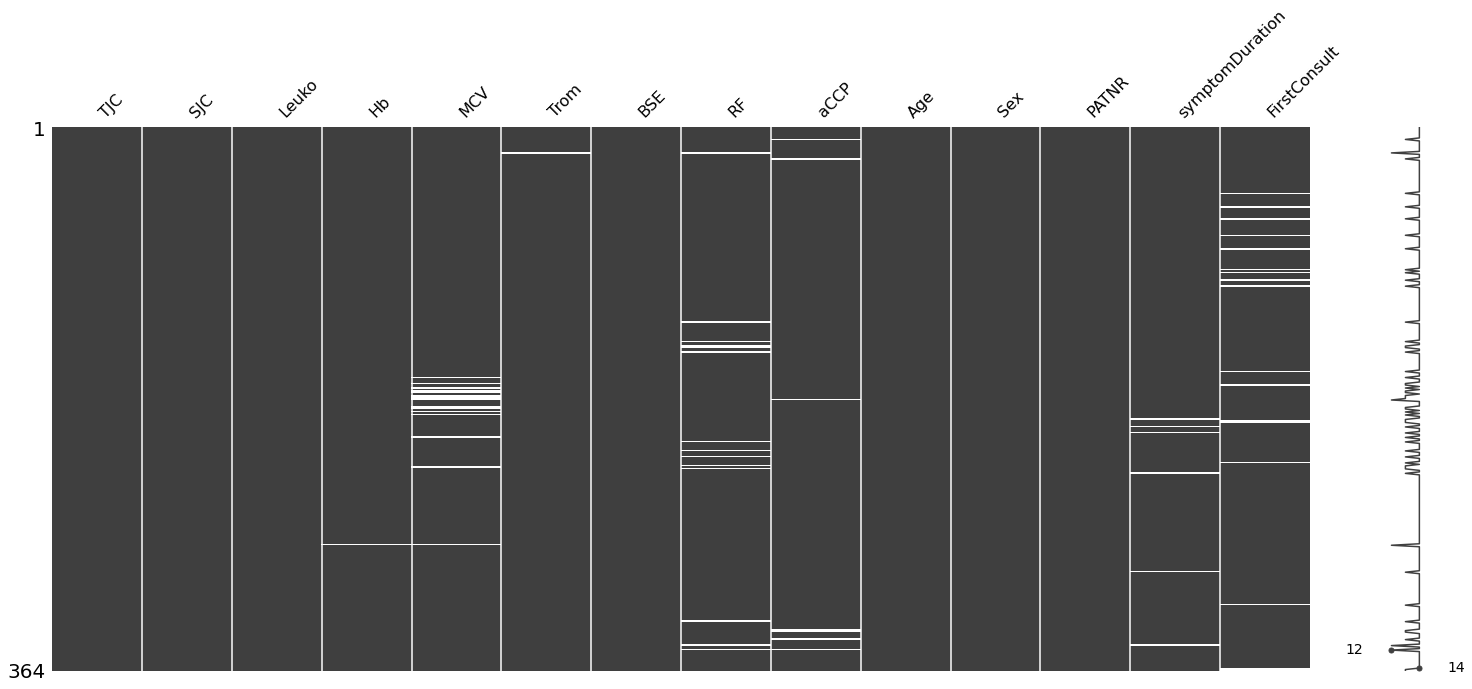

In [12]:
import missingno as msno

l_essential = ['TJC', 'SJC', 'Leuko', 'Hb', 'MCV', 'Trom',  'BSE', 'RF', 'aCCP', 'Age', 'Sex', 'PATNR', 'symptomDuration', 'FirstConsult'] # 'Ht', 
l_interest = ['TJC', 'SJC', 'Leuko', 'Hb', 'MCV', 'Trom',  'BSE', 'RF', 'aCCP', 'Age', 'Sex', 'PATNR', 'symptomDuration', 'DIAGNOSE', 'FirstConsult']

%matplotlib inline
msno.matrix(df[l_essential]) # check if patients that miss variables across lines -> have aCCP / RF of 2df_lab_sc

### Calculate DAS & acquire follow up

In [13]:
import pandas as pd
import numpy as np

def calculate_DAS28(tjc, sjc, esr):
    """
    Calculate DAS28 with 3 variables : TJC, SJC and ESR (BSE)
    """
    #print(esr, tjc, sjc)
    if esr != 0.0:
        das28 = (0.56 * np.sqrt(tjc) + 0.28 * np.sqrt(sjc) + 0.70 * np.log(esr)) * 1.08 + 0.16
    else :
        das28 = np.nan
        print(esr, tjc, sjc)
    return das28

def calculate_DAS44(tjc, sjc, esr):
    """
    Calculate DAS44 with 3 variables : RAI, SJC and ESR (BSE)
    """
    if esr != 0.0:
        das44= (0.53938 * np.sqrt(tjc) + 0.0650 * (sjc) + 0.330 * np.log(esr)) + 0.224 
    else :
        das44 = np.nan
        print(esr, tjc, sjc)
    return das44

file_path = '/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Totaal overzicht ptn.sav'
# Read the Stata file into a pandas DataFrame
df_total = pd.read_spss(file_path)

# Convert the 'Date' columns to datetime format
date_columns = df_total.columns[df_total.columns.str.startswith('Vis')]

def convert_to_datetime(date_string):
    try:
        return pd.to_datetime(date_string)
    except ValueError:
        return np.nan

df_total[date_columns] = df_total[date_columns].applymap(convert_to_datetime)


# Find the largest date per row
df_total['LastDate'] = df_total[date_columns].max(axis=1)
df_total['IDNUM'] = df_total['IDNUM'].astype(float)

date_columns = list(date_columns)
date_columns.extend(['IDNUM', 'LastDate'])
d_lastdate = dict(zip(df_total['IDNUM'], df_total['LastDate']))


df['lastVisit'] = df['PATNR'].apply(lambda x: d_lastdate[ float(x)] if float(x) in d_lastdate.keys() else np.nan)
#df['lastVisit'] = df['lastVisit'].fillna(df['PATNR'].apply(lambda x : d_alt_last[x]))
df['lastVisit'] = pd.to_datetime(df['lastVisit'], format='%Y-%m-%d')

df['followUp'] = df['lastVisit'] -  df['FirstConsult'] 
df['followUp'] = df['followUp'].dt.days


### Show baseline information

In [16]:
df['DAS28'] = df.apply(lambda x : calculate_DAS28(x['TJC'], x['SJC'], x['BSE']), axis=1)
df['DAS44']  = df.apply(lambda x : calculate_DAS44(x['TJC'], x['SJC'], x['BSE']), axis=1)
l_interest =  ['TJC', 'SJC', 'Leuko', 'Hb', 'MCV', 'Trom',  'BSE', 'RF', 'aCCP', 'Age', 'Sex', 'DAS28', 'DAS44', 'PATNR', 'symptomDuration', 'DIAGNOSE', 'FirstConsult', 'followUp']


df_complete = df[l_interest].dropna(subset=l_essential)

df_complete = df_complete.reset_index(drop=True)
df_complete['symptomDuration'] = df_complete['symptomDuration'] * 7
df_complete.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/metadata_improved.csv', sep='|', index=None)


df_summary = pd.DataFrame(columns=['cluster', 'N', 'Sex, F [n(%)]','Age (median+-IQR)', 'RF [n(%)]', 'ACPA [n(%)]', 'ESR (median+-IQR)', 'SJC (median+-IQR)', 'TJC (median+-IQR)', 'RF_na [n(%)]','ACPA_na [n(%)]', 'ESR_na [n(%)]' , 'Mannequin_na [n(%)]', 'DAS44 (median+-IQR)', 'DAS28 (median+-IQR)', 'symptomDuration (median+-IQR)', 'followUp (median+-IQR)']) #TreatSwitch [n(%)]', 


def generate_baseline_essential(df_baseline, name = 'All', frac=''):
    if frac != '' :
        frac = '(' + frac + ')'
    return [name, '%.0f %s' % (len(df_baseline), frac), 
     '%.0f (%.1f)' % (np.sum(df_baseline['Sex']), np.mean(df_baseline['Sex']) * 100), 
     '%.1f (%.1f)' % (np.mean(df_baseline[~df_baseline['Age'].isna()]['Age']), np.std(df_baseline[~df_baseline['Age'].isna()]['Age'])),
     '%.0f (%.1f)' % (np.sum(df_baseline['RF']), np.mean(df_baseline['RF']) * 100), 
     '%.0f (%.1f)' % (np.sum(df_baseline['aCCP']), np.mean(df_baseline['aCCP']) * 100), 
       
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['BSE'].isna()]['BSE']), IQR(df_baseline[~df_baseline['BSE'].isna()]['BSE'])[0], IQR(df_baseline[~df_baseline['BSE'].isna()]['BSE'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['SJC'].isna()]['SJC']), IQR(df_baseline[~df_baseline['SJC'].isna()]['SJC'])[0], IQR(df_baseline[~df_baseline['SJC'].isna()]['SJC'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['TJC'].isna()]['TJC']), IQR(df_baseline[~df_baseline['TJC'].isna()]['TJC'])[0], IQR(df_baseline[~df_baseline['TJC'].isna()]['TJC'])[1]),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['RF'].isna()]), (len(df_baseline[df_baseline['RF'].isna()])/len(df_baseline))*100), '%.0f (%.1f)' % (len(df_baseline[df_baseline['aCCP'].isna()]), (len(df_baseline[df_baseline['aCCP'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['BSE'].isna()]), (len(df_baseline[df_baseline['BSE'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['SJC'].isna()]), (len(df_baseline[df_baseline['SJC'].isna()])/len(df_baseline))*100),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline['DAS44']), IQR(df_baseline['DAS44'])[0], IQR(df_baseline['DAS44'])[1]) ,
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline['DAS28']), IQR(df_baseline['DAS28'])[0], IQR(df_baseline['DAS28'])[1]) ,
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['symptomDuration'].isna()]['symptomDuration']), IQR(df_baseline[~df_baseline['symptomDuration'].isna()]['symptomDuration'])[0], IQR(df_baseline[~df_baseline['symptomDuration'].isna()]['symptomDuration'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['followUp'].isna()]['followUp']), IQR(df_baseline[~df_baseline['followUp'].isna()]['followUp'])[0], IQR(df_baseline[~df_baseline['followUp'].isna()]['followUp'])[1]),
            
            
    ]

df_summary.loc[0] = generate_baseline_essential(df_complete, 'All')

df_summary = df_summary.reset_index(drop=True)
df_summary.T

,0
cluster,All
N,307
"Sex, F [n(%)]",211 (68.7)
Age (median+-IQR),53.1 (14.1)
RF [n(%)],219 (71.3)
ACPA [n(%)],201 (65.5)
ESR (median+-IQR),29.0 (15.0-42.0)
SJC (median+-IQR),8.0 (4.0-12.0)
TJC (median+-IQR),7.0 (5.0-11.0)
RF_na [n(%)],0 (0.0)


## #2. Project new data

Load different custom env: 
conda activate /exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/

### #2.1 Force same dimensions
We have less caterogical features in the replication set, thus we are required to reduce the dimensions. In order to create a shared latent space in the next step

In [1]:
import pandas as pd

l_num = ['Leuko', 'Hb', 'MCV', 'Trom', 'BSE', 'Age'] # no Ht

l_cat_shared = list(pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/improved_columns_cat.csv', sep='|')['Columns'].values)
l_cat_patnr =  l_cat_shared[:-1]
l_cat_patnr.append('PATNR')

# Variables from development set
df_numeric = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_lab_scaled_demographics.csv', sep=',')
df_numeric['PATNR'] = df_numeric['pseudoId']
df_numeric = df_numeric[l_num].copy()
df_categoric= pd.read_csv('../../new_data/5_clustering/df_categoric_wAge.csv', sep=',')[l_cat_shared]
df_categoric['PATNR'] = df_categoric['pseudoId']

l_num.append('PATNR')

# Variables from replication set
df_categoric_replication = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/df_improved_categoric_ohe.csv', sep='|')[l_cat_patnr]
df_numeric_replication = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Improved_Lab_wide_scaled.csv', sep='|')[l_num]


# Select complete patients
l_essential = ['SJC', 'Leuko', 'Hb', 'MCV', 'Trom',  'BSE', 'RF', 'aCCP', 'Age', 'Sex', 'PATNR'] #  'Ht',
df_meta = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/metadata_improved.csv', sep='|')
l_pat_repl = list(df_meta[l_essential].dropna()['PATNR'].unique())

df_categoric_replication = df_categoric_replication[df_categoric_replication['PATNR'].isin(l_pat_repl)].copy()
df_numeric_replication = df_numeric_replication[df_numeric_replication['PATNR'].isin(l_pat_repl)].copy()

# Reset index
df_categoric_replication = df_categoric_replication.reset_index(drop= True)
df_numeric_replication = df_numeric_replication.reset_index(drop= True)

df_categoric_replication = df_categoric_replication.fillna(0)
df_numeric_replication = df_numeric_replication.fillna(0)

In [ ]:
import pandas as pd
df_numeric = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_lab_scaled_demographics.csv', sep=',')
df_numeric['PATNR'] = df_numeric['pseudoId']
#df_numeric

### Create combined metadata
- not sure if we really need this... (Cant we just use the other metadata)

In [7]:
df_numeric_raw = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Improved_Lab_wide_unscaled.csv', sep='|')[l_num]

df_meta = pd.merge(df_categoric_replication, df_numeric_raw, left_on='PATNR', right_on='PATNR')
df_meta['pseudoId'] = df_meta['PATNR'] 

# import metadata of development set
metadata_RA = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270.csv', index_col=0) #  pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_metadata.csv')
metadata_RA['Replication'] = 0
metadata_RA['PATNR'] = metadata_RA['pseudoId'].str[:-2] 

df_meta['Replication'] = 1
df_meta['pseudoId'] = df_meta['PATNR'].copy()

df_meta_full = pd.concat([df_meta, metadata_RA])
df_meta_full.reset_index(drop=True)
df_meta_full.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Metadata_complete.csv', sep='|', index=False)

### #2.2 learn shared product space

In [8]:
import os, platform, subprocess, re

def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

get_processor_name() # NEEDED :' Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz'

' Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz'

In [ ]:
import time
import numpy as np
from mmae.multimodal_autoencoder import MultimodalAutoencoder # MMAE
import tensorflow as tf


# Be aware: Remove features with zero variation!!


# Use pseudo labels

# Build the model on Original set

input_shapes = {'Categoric': df_categoric[l_cat_patnr[:-1]].shape[1:], 'Numeric': df_numeric[l_num[:-1]].shape[1:]} 
data = [np.array(df_categoric[l_cat_patnr[:-1]].values), np.array(df_numeric[l_num[:-1]].values)]

# Number of units of each layer of encoder network
hidden_dims = [128, 64, 8] 
# Output activation functions for each modality
output_activations = ['sigmoid' , 'relu'] 
# Name of Keras optimizer
optimizer = 'adam'
# Loss functions corresponding to a noise model for each modality
loss = ['bernoulli_divergence', 'gaussian_divergence']

# Set seed
#tf.keras.utils.set_random_seed(1234)
tf.random.set_seed(1234567)

# Construct autoencoder network
autoencoder = MultimodalAutoencoder(input_shapes, hidden_dims,
                                    output_activations)
autoencoder.compile(optimizer, loss)


t0 = time.time()
# Train model where input and output are the same
history = autoencoder.fit(data, epochs=100) 

t1 = time.time()
print('Time to create product space: ' + str(t1-t0))


# Get Latent space of original data
z_filtered = autoencoder.encode(data)

autoencoder.save('/exports/reum/tdmaarseveen/RA_Clustering/models/IMPROVED_MMAE')

# Save shared productspace (that only uses variables also present in replication set)
l_embedding = ['PATNR']

df_z = pd.DataFrame(z_filtered)
for ix, col in enumerate(df_z): # z-filtered might be row based
    df_z['LF%s' % ix] = df_z[ix].copy()
    l_embedding.append('LF%s' % ix)
 
metadata_RA = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270.csv', index_col=0)
df_z.insert(0, 'PATNR', metadata_RA['pseudoId'])
df_z = df_z[l_embedding].copy()
   
df_z[l_embedding].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/results/embedding/IMPROVED_embedding.csv', index=False, sep=',')

### Also save model as tfjs, h5 & keras

In [ ]:

import tensorflow as tf
import tensorflowjs as tfjs

model=tf.keras.models.load_model('/exports/reum/tdmaarseveen/RA_Clustering/models/IMPROVED_MMAE', compile=False)

autoencoder.save('/exports/reum/tdmaarseveen/RA_Clustering/models/IMPROVED_MMAE_TFJS/mmae_improved_new', save_format='keras')
autoencoder.save('/exports/reum/tdmaarseveen/RA_Clustering/models/IMPROVED_MMAE_TFJS/mmae_improved_new.h5', save_format='h5')

tfjs.converters.save_keras_model(model.encoder, '/exports/reum/tdmaarseveen/RA_Clustering/models/IMPROVED_MMAE_TFJS/encoder')

### #2.3 Project novel instances onto latent embedding


In [ ]:
df_imp = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Metadata_complete.csv', sep='|')
df_imp = df_imp[df_imp['Replication']==1].copy()
df_imp['SJC'] =df_imp[[col for col in df_imp.columns if ('Zwelling_' in col and 'positive' in col)]].sum(axis=1)
df_imp['TJC'] =df_imp[[col for col in df_imp.columns if  ('Pijn_' in col and 'positive' in col)]].sum(axis=1)

In [19]:
import sys
#sys.path.append(r'../../modules/parametric_tsne/')
#sys.path.append(r'../../modules/')
sys.path.append(r'../../src/1_emr_scripts')
import Visualization as func
from sklearn.manifold import TSNE

# --------------------------------- Add new patients ---------------------------------------------
model=tf.keras.models.load_model('/exports/reum/tdmaarseveen/RA_Clustering/models/IMPROVED_MMAE', compile=False)

# Project new sample in product space

metadata_rep = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/metadata_improved.csv', sep='|')
df_categoric_replication  = df_categoric_replication.fillna(0)
#z_patient = maui_model.transform({ 'Categorical': df_categoric_replication.T, 'Lab_numerical': df_numeric_replication.T})
lcat = [col for col in df_categoric_replication.columns if col not in ['PATNR']]
lnum = [col for col in df_numeric_replication.columns if col not in ['PATNR']]
data = [np.array(df_categoric_replication[lcat].values), np.array(df_numeric_replication[lnum].values)]

z_patient = model.encoder.predict(data, batch_size=256)
z_patient = pd.DataFrame(z_patient)

l_embedding = ['PATNR']
for ix, col in enumerate(z_patient): # z-filtered might be row based
    z_patient['LF%s' % ix] = z_patient[ix].copy()
    l_embedding.append('LF%s' % ix)

z_patient.insert(0, 'PATNR', metadata_rep['PATNR'])

# Add new patient to product space
df_z = df_z.append(z_patient[l_embedding], ignore_index = True)

# --------------------------------- Add new patients ---------------------------------------------

# Create interactive TSNE with metadata
X_embedded = TSNE(n_components=2, random_state=7062021).fit_transform(df_z[df_z.columns[1:]])


# Open metadata
df_imp = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Metadata_complete.csv', sep='|')
df_imp['SJC'] =df_imp[[col for col in df_imp.columns if ('Zwelling_' in col and 'positive' in col)]].sum(axis=1)
df_imp['TJC'] =df_imp[[col for col in df_imp.columns if  ('Pijn_' in col and 'positive' in col)]].sum(axis=1)
df_imp['patnr'] = range(len(df_imp))


# Get more insight by visualizing the ratios
df_imp['Swollen ratio'] = df_imp['SJC'] / (df_imp['SJC']+df_imp['TJC'])
df_imp['Swollen ratio'] = df_imp['Swollen ratio'].fillna(0)

df_imp['Tender ratio'] = df_imp['TJC'] / (df_imp['SJC']+df_imp['TJC'])
df_imp['Tender ratio'] = df_imp['Tender ratio'].fillna(0)

df_imp['Big ratio'] = df_imp['Big joints'] / (df_imp['TJC']+df_imp['SJC'])
df_imp['Big ratio'] = df_imp['Big ratio'].fillna(0)

df_imp['Small ratio'] = df_imp['Small joints'] / (df_imp['TJC']+df_imp['SJC'])
df_imp['Small ratio'] = df_imp['Small ratio'].fillna(0)

df_imp['Symmetrical ratio'] = df_imp['Symmetrical joints'] / (df_imp['TJC']+df_imp['SJC'])
df_imp['Symmetrical ratio'] = df_imp['Symmetrical ratio'].fillna(0)

# write coordinates embedding
df_imp['coor_x'] = X_embedded[:, 0]
df_imp['coor_y'] = X_embedded[:, 1]

# update column
df_imp['PATNR'] = df_z['PATNR'].copy()

# Save embedding + projection
df_z.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/results/embedding/IMPROVED_embedding_projections.csv', index=False, sep=',')

func.visualize_umap_bokeh_na_2(X_embedded, df_imp, list(df_imp.columns), l_binary=l_cat_patnr, patient_id='PATNR', cluster_id='RF', title='MMAE_UMAP',  path='/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/IMPROVED_MMAE.html')

/tmp/ipykernel_2556620/3275459841.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_z = df_z.append(z_patient[l_embedding], ignore_index = True)
/exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


1694 1694
0 []


ERROR:bokeh.core.validation.check:E-1019 (DUPLICATE_FACTORS): FactorRange must specify a unique list of categorical factors for an axis: duplicate factors found: 'e', 'l', 'i', 'n', 'g', '_', 'o'



UMAP figure saved under location: TSNE/Baseline_MMAE_UMAP.html


### Show in 2d space

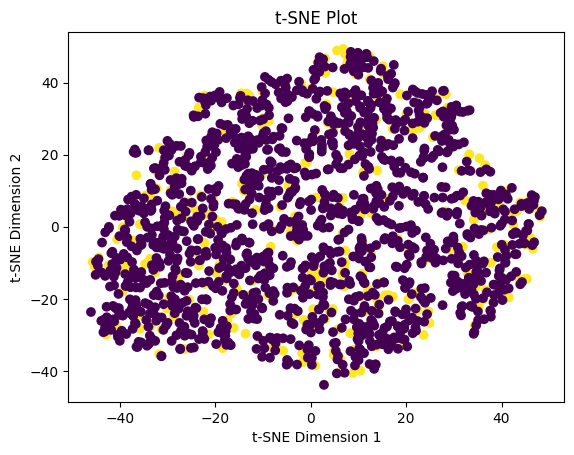

In [20]:
import matplotlib.pyplot as plt
# Plot t-SNE
plt.scatter(df_imp['coor_x'], df_imp['coor_y'], c= df_imp['Replication'])
plt.title('t-SNE Plot')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## #3 Classify novel instances (POODLE)

### #3.1 Initialize variables for patient assignment

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

# Construct patient similarity matrix from original set
sim_matrix = cosine_similarity(z_filtered.astype(np.float32))

# Specify columns for each modality (need to be present in both original & replication space)
d_input = {'cat' : list(df_categoric_replication[lcat].columns), 'num' : list(df_numeric_replication[lnum].columns)}

# Intialize list to save location of newly projected patients
z_new = []

# Define cluster
CLUSTER_LABEL = 'PhenoGraph_clusters'

# Initialize dataframe where we collect all predictors of interest for assigning patients to a cluster 
archetype_columns = ['weight_pval', 'weight_mean', 'weight_sd', 'cluster_mean_pat', 'cluster_sd_pat'] # + latent factors?
l_col = ['pseudoId', CLUSTER_LABEL]
for i in range(len(np.unique(df_cluster[CLUSTER_LABEL]))):
    l_col.extend(['%s_%s' % (col, i) for col in archetype_columns ])

df_characteristics = pd.DataFrame(columns=l_col)

### #3.2 Project the patients onto latent space and see how they are oriented

In [25]:
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import utils as pup
import importlib as imp
imp.reload(pup)
np.seterr('raise') # reveal potential floating point errors

# Bookmark identifier (use fake)
df_id = pd.DataFrame({'pseudoId' : ['id_' + str(i) for i in range(len(df_numeric_replication))]})

for ix, new_pat in enumerate(df_id['pseudoId']):
    # collect sample information
    new_pat = str(df_id.iloc[ix]['pseudoId'])
    sample_cat = df_categoric_replication[lcat].iloc[ix]
    sample_num = df_numeric_replication[lnum].iloc[ix]
    #sample =  sample_cat.append(sample_num)
    sample = pd.concat([sample_cat, sample_num], axis=0)
    sample.name = new_pat

    # create metadata
    df_meta = pup.getMetaDataPatient(df_cluster, list(df_cluster['pseudoId'].values), new_pat)
    
    l_orientation = [df_id.iloc[ix]['pseudoId'], -1]
    
    # What is the orientation of the patient compared to each cluster
    # In other words, which cluster has the largest gravity on the patient
    l_orientation.extend(pup.getOrientation(autoencoder, df_meta, pd.DataFrame(z_filtered, columns=l_embedding[1:]), d_input, sample, sim_matrix=sim_matrix, cluster_label='PhenoGraph_clusters'))

    # Bookmark cluster characteristics
    df_characteristics.loc[len(df_characteristics)] = l_orientation
    
df_characteristics['pseudoId'] = df_id['pseudoId'].copy()
df_characteristics.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/ClusterCharacteristics_Projection_IMPROVED.csv', index=False, sep=',')
df_characteristics.head()

,pseudoId,PhenoGraph_clusters,weight_pval_0,weight_mean_0,weight_sd_0,cluster_mean_pat_0,cluster_sd_pat_0,weight_pval_1,weight_mean_1,weight_sd_1,...,weight_pval_2,weight_mean_2,weight_sd_2,cluster_mean_pat_2,cluster_sd_pat_2,weight_pval_3,weight_mean_3,weight_sd_3,cluster_mean_pat_3,cluster_sd_pat_3
0,id_0,-1,1.000000,0.89219,0.076735,0.922616,0.055339,0.000001,0.936355,0.043221,...,1.000000,0.923184,0.051269,0.939682,0.038579,1.000000,0.794624,0.137986,0.855608,0.086927
1,id_1,-1,0.009248,0.89219,0.076735,0.886369,0.049802,1.000000,0.936355,0.043221,...,1.000000,0.923184,0.051269,0.948011,0.035350,0.000009,0.794624,0.137986,0.767063,0.102536
2,id_2,-1,0.006457,0.89219,0.076735,0.884258,0.064414,0.000001,0.936355,0.043221,...,0.000001,0.923184,0.051269,0.876043,0.064409,0.087722,0.794624,0.137986,0.785315,0.111553
3,id_3,-1,1.000000,0.89219,0.076735,0.918702,0.059839,0.000001,0.936355,0.043221,...,0.000001,0.923184,0.051269,0.875608,0.054960,1.000000,0.794624,0.137986,0.878254,0.078007
4,id_4,-1,0.008672,0.89219,0.076735,0.886053,0.051999,1.000000,0.936355,0.043221,...,0.000001,0.923184,0.051269,0.900692,0.051198,0.000001,0.794624,0.137986,0.752987,0.105621


### #3.3 Build Poodle classifier

#### #3.3.1 Quantify orientation of original samples with respect to clusters

In [ ]:
import pandas as pd
import numpy as np
from math import exp
from scipy.stats import ttest_ind
from scipy.spatial.distance import cosine# cosine minkowski
from sklearn.metrics.pairwise import cosine_similarity
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import utils as pup

CLUSTER_LABEL = 'PhenoGraph_clusters'

# Initialize similarity matrix
# We only need to calculate the pairwise similarities of the initial space 1 time
sim_matrix = cosine_similarity(z_filtered.astype(np.float32))

df_characteristics_original = pup.quantifySimilarity(df_cluster, sim_matrix, CLUSTER_LABEL = 'PhenoGraph_clusters')
    
# Bookmark cluster characteristics
df_characteristics_original['pseudoId'] = df_cluster['pseudoId'].copy()
df_characteristics_original[CLUSTER_LABEL] = df_cluster[CLUSTER_LABEL].copy()
df_characteristics_original.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/ClusterCharacteristics_Original.csv', index=False, sep=',')
df_characteristics_original.head()

#### #3.3.2 Optimize weights with simple classifier

TRAIN: [222 223 224 225 226 227 228 229 230 231] TEST: [0 1 2 3 4 5 6 7 8 9]
[16:52:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [222 223 224 225 226 227 228 229 230 231]
[16:52:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [444 445 446 447 448 449 450 451 452 453]
[16:52:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [666 667 668 669 670 671 672 673 674 675]
[16:52:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [888 889 890 891 892 893 894 895 896 897]
[16:52:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.



Text(0.5, 1.0, 'Confusion matrix for the Poodle labeler (XGB) on trainingsset (ACC: 1.00)')

<Figure size 640x480 with 0 Axes>

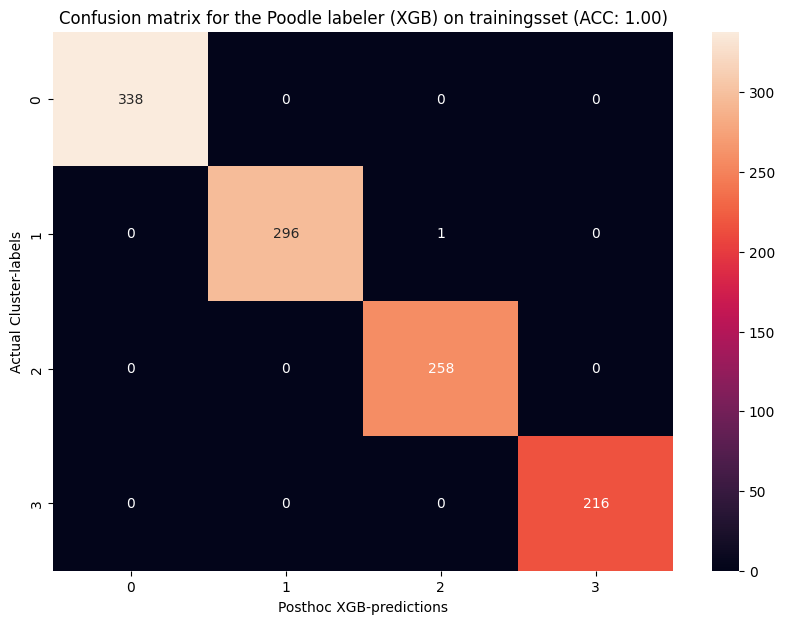

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

df_train, df_test = train_test_split(df_characteristics_original, test_size=0.2,  random_state=28072022) # stratify=df_characteristics['PhenoGraph_clusters'],

target = 'PhenoGraph_clusters'

cols_data = [x for x in list(df_train.columns) if x not in ['pseudoId', target]] #   'Sex', 'Age', 

X = df_train[cols_data].values
y = df_train[target]

# Apply 5 fold CV
kf = KFold(n_splits=5) # 
iteration = 0
y_pred = []
y_proba = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    X_train, X_test = pd.DataFrame(X).loc[train_index], pd.DataFrame(X).loc[test_index]
    y_train, y_test = np.take(y, np.array(train_index)),np.take(y, np.array(test_index))#.values  # .values

    # Z-score scaling
    scaler = StandardScaler().fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model is an XGBClassifier
    n_trees = 50
    dmat_train = xgb.DMatrix(X_train, y_train)
    dmat_test = xgb.DMatrix(X_test, y_test)
    
    t0 = time.time()
    xgb_clf = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', num_class=len(y.unique()), n_trees=50)
    xgb_clf = xgb_clf.fit(X_train, y_train)

    
    t1 = time.time()
    iteration += 1
    
    y_proba.extend(xgb_clf.predict_proba(X_test))
    y_pred.extend(xgb_clf.predict(X_test))
    
fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)


df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Poodle labeler (XGB) on trainingsset (ACC: %.2f)' % (accuracy))

#### #3.3.3 Show performance on hold-out test set

Text(0.5, 1.0, 'Confusion matrix for the Poodle labeler (XGB) in independent test set (ACC: 1.00)')

<Figure size 640x480 with 0 Axes>

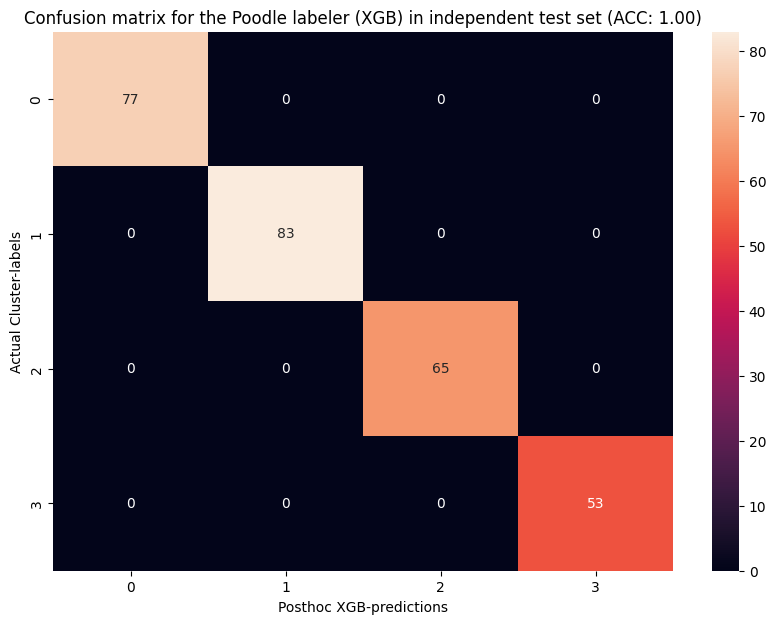

In [29]:
X_test_final = df_test[cols_data].values
y_test_final = df_test[target]

# Z-score scaling
#scaler = StandardScaler().fit(X_test)
X_test_final = scaler.transform(X_test_final)
y_pred_final = xgb_clf.predict(X_test_final)


fig = plt.figure()
cm = confusion_matrix(y_test_final, y_pred_final)
accuracy = accuracy_score(y_test_final, y_pred_final)


df_cm = pd.DataFrame(cm, index = list(range(len(y_test_final.unique()))),
                  columns = list(range(len(y_test_final.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Poodle labeler (XGB) in independent test set (ACC: %.2f)' % (accuracy))

#### #3.3.4 Compare to dummy classifier

Text(0.5, 1.0, 'Confusion matrix for the Dummy labeler (XGB) in independent test set (ACC: 0.57)')

<Figure size 640x480 with 0 Axes>

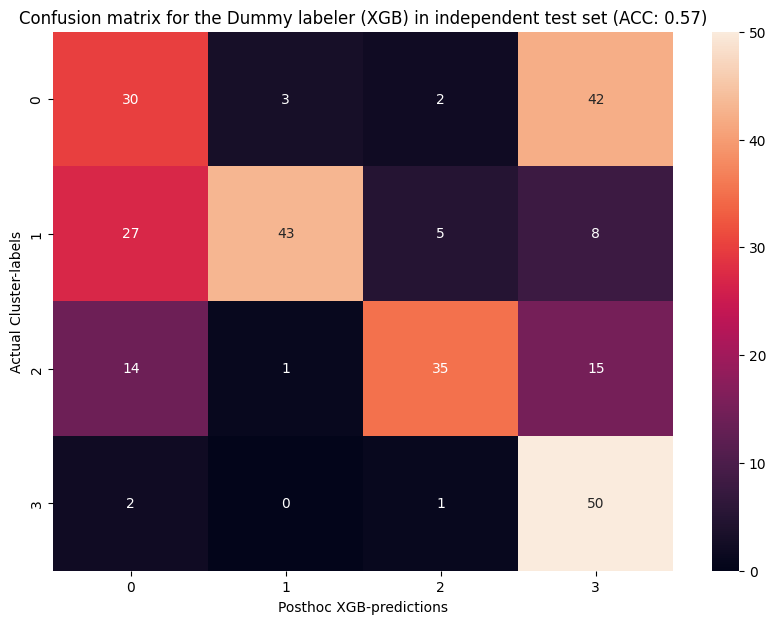

In [30]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score

def dummyLabeler(X):
    return np.argmax(X) # largest p

target = 'PhenoGraph_clusters'

X = df_test[[col for col in df_test.columns if 'weight_pval' in col]].copy()
y = df_test[target]

y_pred = []

for ix in range(len(X)): # loop through patients
    y_pred.append(dummyLabeler(X.iloc[ix]))

fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Dummy labeler (XGB) in independent test set (ACC: %.2f)' % (accuracy))

#### #3.3.5 Train final model on all labeled data & Save model

In [33]:
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt

import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from pickle import dump

X_all = df_characteristics_original[cols_data]
y_all = df_characteristics_original[CLUSTER_LABEL]

scaler = StandardScaler().fit(X_all)

X_all = scaler.transform(X_all)

dmat_train = xgb.DMatrix(X_all, y_all)

t0 = time.time()
bst  = xgb.train({'objective': 'multi:softmax',  'eval_metric':'merror', 'num_class':len(y.unique())}, dmat_train, 
                    n_trees, evals=[(dmat_train, "train")]) 
t1 = time.time()

# save poodle labeler
bst.save_model("../../models/IMPROVED_poodle/xgb_model.json")

# save scaler
dump(scaler, open('../../models/IMPROVED_poodle/scaler.pkl', 'wb'))


[0]	train-merror:0.00000
[1]	train-merror:0.00000
[2]	train-merror:0.00000
[3]	train-merror:0.00000
[4]	train-merror:0.00000
[5]	train-merror:0.00000
[6]	train-merror:0.00000
[7]	train-merror:0.00000
[8]	train-merror:0.00000
[9]	train-merror:0.00000
[10]	train-merror:0.00000
[11]	train-merror:0.00000
[12]	train-merror:0.00000
[13]	train-merror:0.00000
[14]	train-merror:0.00000
[15]	train-merror:0.00000
[16]	train-merror:0.00000
[17]	train-merror:0.00000
[18]	train-merror:0.00000
[19]	train-merror:0.00000
[20]	train-merror:0.00000
[21]	train-merror:0.00000
[22]	train-merror:0.00000
[23]	train-merror:0.00000
[24]	train-merror:0.00000
[25]	train-merror:0.00000
[26]	train-merror:0.00000
[27]	train-merror:0.00000
[28]	train-merror:0.00000
[29]	train-merror:0.00000
[30]	train-merror:0.00000
[31]	train-merror:0.00000
[32]	train-merror:0.00000
[33]	train-merror:0.00000
[34]	train-merror:0.00000
[35]	train-merror:0.00000
[36]	train-merror:0.00000
[37]	train-merror:0.00000
[38]	train-merror:0.00

### #3.4 Use POODLE to cluster new instances

In [ ]:
import sys
sys.path.append(r'../')
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import utils as pup
import pandas as pd
from pickle import load

df_new = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/ClusterCharacteristics_Projection_IMPROVED.csv', sep=',')

# Define input columns
target = 'PhenoGraph_clusters'
cols_data = [x for x in list(df_new.columns) if x not in ['pseudoId', target]]

# Classify patients
X_replication = df_new[cols_data]#.

# load the scaler
scaler = load(open('../../models/IMPROVED_poodle/scaler.pkl', 'rb'))
#X_replication = scaler.transform(X_replication)

df_new['PhenoGraph_clusters'] = pup.classifyPatient(X_replication, path="../../models/IMPROVED_poodle/")
df_new.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/ClusterAssignment_IMPROVED.csv', index=False, sep=',')

# Original clustering information (same samples as development set)
# df_cluster = metadata_RA[['pseudoId', 'PhenoGraph_clusters']].copy()

df_new.head()

Spatial variance in original set: 	C1= 415; C2= 380; C3= 323; C4= 269
Spatial variance in  replication set: 	C1= 90; C2= 102; C3= 50; C4= 65


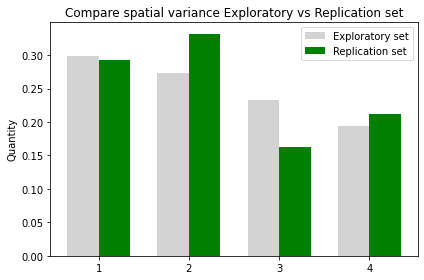

In [53]:
import pandas as pd
from collections import Counter
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import visualization as viz

df_old = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/IMPROVED_Complete_META.csv', sep=';')[['pseudoId', 'Replication', 'PhenoGraph_clusters']]
df_old = df_old[df_old['Replication']==0].copy()

df_cluster = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/ClusterAssignment_IMPROVED.csv', sep=',')
df_cluster = df_cluster[['pseudoId','PhenoGraph_clusters']].copy()


# C1= 90; C2= 102; C3= 50; C4= 65

c = Counter(df_old['PhenoGraph_clusters'])
l_old = [c[ix]/sum(c.values()) for ix in range(0,len(c))]
print('Spatial variance in original set: \tC' + '; C'.join([str(ix+1) + '= ' + str(c[ix]) for ix in range(0,len(c))]))
c = Counter(df_cluster['PhenoGraph_clusters'])
l_new = [c[ix]/sum(c.values()) for ix in range(0,len(c))]
print('Spatial variance in  replication set: \tC' + '; C'.join([str(ix+1) + '= ' + str(c[ix]) for ix in range(0,len(c))]))

viz.plotSpatialVariation(l_new, l_old)

## Create metadata w/ clusters

In [61]:
l_columns = [
    "PATNR", "PhenoGraph_clusters", "Leuko", "Hb", "MCV", "Trom", "BSE", "Age", "RF", "aCCP", "Sex", "Age_Early", "Age_Late", 
    "Pijn_acromioclaviaculair R_negative", "Pijn_acromioclaviaculair R_positive", 
    "Pijn_acromioclaviaculair L_negative", "Pijn_acromioclaviaculair L_positive", 
    "Zwelling_acromioclaviaculair R_negative", "Zwelling_acromioclaviaculair R_positive", 
    "Zwelling_acromioclaviaculair L_negative", "Zwelling_acromioclaviaculair L_positive", 
    "Pijn_bovenste spronggewricht rechts_negative", "Pijn_bovenste spronggewricht rechts_positive", 
    "Pijn_bovenste spronggewicht links_negative", "Pijn_bovenste spronggewicht links_positive", 
    "Zwelling_bovenste spronggewricht rechts_negative", "Zwelling_bovenste spronggewricht rechts_positive", 
    "Zwelling_bovenste spronggewicht links_negative", "Zwelling_bovenste spronggewicht links_positive", 
    "Pijn_onderste spronggewricht rechts_negative", "Pijn_onderste spronggewricht rechts_positive", 
    "Pijn_onderste spronggewricht links_negative", "Pijn_onderste spronggewricht links_positive", 
    "Zwelling_onderste spronggewricht rechts_negative", "Zwelling_onderste spronggewricht rechts_positive", 
    "Zwelling_onderste spronggewricht links_negative", "Zwelling_onderste spronggewricht links_positive", 
    "Pijn_elleboog R_negative", "Pijn_elleboog R_positive", "Pijn_Elleboog L_negative", "Pijn_Elleboog L_positive", 
    "Zwelling_elleboog R_negative", "Zwelling_elleboog R_positive", "Zwelling_Elleboog L_negative", 
    "Zwelling_Elleboog L_positive", "Pijn_IP rechts_negative", "Pijn_IP rechts_positive", "Pijn_IP links_negative", 
    "Pijn_IP links_positive", "Pijn_pip 2 rechts hand_negative", "Pijn_pip 2 rechts hand_positive", 
    "Pijn_pip 2 links hand_negative", "Pijn_pip 2 links hand_positive", "Pijn_pip 3 rechts hand_negative", 
    "Pijn_pip 3 rechts hand_positive", "Pijn_pip 3 links hand_negative", "Pijn_pip 3 links hand_positive", 
    "Pijn_pip 4 links hand_negative", "Pijn_pip 4 links hand_positive", "Pijn_pip 4 rechts hand_negative", 
    "Pijn_pip 4 rechts hand_positive", "Pijn_pip 5 rechts hand_negative", "Pijn_pip 5 rechts hand_positive", 
    "Pijn_pip 5 links hand_negative", "Pijn_pip 5 links hand_positive", "Pijn_dip 2 rechts_negative", 
    "Pijn_dip 2 rechts_positive", "Pijn_dip 2 links_negative", "Pijn_dip 2 links_positive", 
    "Pijn_dip 3 rechts_negative", "Pijn_dip 3 rechts_positive", "Pijn_dip 3 links_negative", "Pijn_dip 3 links_positive", 
    "Pijn_dip 4 rechts_negative", "Pijn_dip 4 rechts_positive", "Pijn_dip 4 links_negative", "Pijn_dip 4 links_positive", 
    "Pijn_dip 5 rechts_negative", "Pijn_dip 5 rechts_positive", "Pijn_dip 5 links_negative", "Pijn_dip 5 links_positive", 
    "Zwelling_IP rechts_negative", "Zwelling_IP rechts_positive", "Zwelling_IP links_negative", "Zwelling_IP links_positive", 
    "Zwelling_pip 2 rechts hand_negative", "Zwelling_pip 2 rechts hand_positive", "Zwelling_pip 2 links hand_negative", 
    "Zwelling_pip 2 links hand_positive", "Zwelling_pip 3 rechts hand_negative", "Zwelling_pip 3 rechts hand_positive", 
    "Zwelling_pip 3 links hand_negative", "Zwelling_pip 3 links hand_positive", "Zwelling_pip 4 rechts hand_negative", 
    "Zwelling_pip 4 rechts hand_positive", "Zwelling_pip 4 links hand_negative", "Zwelling_pip 4 links hand_positive", 
    "Zwelling_pip 5 rechts hand_negative", "Zwelling_pip 5 rechts hand_positive", "Zwelling_pip 5 links hand_negative", 
    "Zwelling_pip 5 links hand_positive", "Zwelling_dip 2 rechts_negative", "Zwelling_dip 2 rechts_positive", 
    "Zwelling_dip 2 links_negative", "Zwelling_dip 2 links_positive", "Zwelling_dip 3 rechts_negative", 
    "Zwelling_dip 3 rechts_positive", "Zwelling_dip 3 links_negative", "Zwelling_dip 3 links_positive", 
    "Zwelling_dip 4 rechts_negative", "Zwelling_dip 4 rechts_positive", "Zwelling_dip 4 links_negative", 
    "Zwelling_dip 4 links_positive", "Zwelling_dip 5 rechts_negative", "Zwelling_dip 5 rechts_positive", 
    "Zwelling_dip 5 links_negative", "Zwelling_dip 5 links_positive", "Pijn_knie rechts_negative", 
    "Pijn_knie rechts_positive", "Pijn_knie links_negative", "Pijn_knie links_positive", "Zwelling_knie rechts_negative", 
    "Zwelling_knie rechts_positive", "Zwelling_knie links_negative", "Zwelling_knie links_positive", 
    "Pijn_mcp 1 rechts_negative", "Pijn_mcp 1 rechts_positive", "Pijn_mcp 1 links_negative", "Pijn_mcp 1 links_positive", 
    "Pijn_mcp 2 rechts_negative", "Pijn_mcp 2 rechts_positive", "Pijn_mcp 2 links_negative", "Pijn_mcp 2 links_positive", 
    "Pijn_mcp 3 rechts_negative", "Pijn_mcp 3 rechts_positive", "Pijn_mcp 3 links_negative", "Pijn_mcp 3 links_positive", 
    "Pijn_mcp 4 rechts_negative", "Pijn_mcp 4 rechts_positive", "Pijn_mcp 4 links_negative", "Pijn_mcp 4 links_positive", 
    "Pijn_mcp 5 links_negative", "Pijn_mcp 5 links_positive", "Pijn_mcp 5 rechts_negative", "Pijn_mcp 5 rechts_positive", 
    "Zwelling_mcp 1 rechts_negative", "Zwelling_mcp 1 rechts_positive", "Zwelling_mcp 1 links_negative", 
    "Zwelling_mcp 1 links_positive", "Zwelling_mcp 2 rechts_negative", "Zwelling_mcp 2 rechts_positive", 
    "Zwelling_mcp 2 links_negative", "Zwelling_mcp 2 links_positive", "Zwelling_mcp 3 rechts_negative", 
    "Zwelling_mcp 3 rechts_positive", "Zwelling_mcp 3 links_negative", "Zwelling_mcp 3 links_positive", 
    "Zwelling_mcp 4 rechts_negative", "Zwelling_mcp 4 rechts_positive", "Zwelling_mcp 4 links_negative", 
    "Zwelling_mcp 4 links_positive", "Zwelling_mcp 5 rechts_negative", "Zwelling_mcp 5 rechts_positive", 
    "Zwelling_mcp 5 links_negative", "Zwelling_mcp 5 links_positive", "Pijn_tarsometatarsaal R_negative", 
    "Pijn_tarsometatarsaal R_positive", "Pijn_tarsometatarsaal L_negative", "Pijn_tarsometatarsaal L_positive", 
    "Zwelling_tarsometatarsaal R_negative", "Zwelling_tarsometatarsaal R_positive", "Zwelling_tarsometatarsaal L_negative", 
    "Zwelling_tarsometatarsaal L_positive", "Pijn_mtp 1 rechts_negative", "Pijn_mtp 1 rechts_positive", 
    "Pijn_mtp 1 links_negative", "Pijn_mtp 1 links_positive", "Pijn_mtp 2 rechts_negative", "Pijn_mtp 2 rechts_positive", 
    "Pijn_mtp 2 links_negative", "Pijn_mtp 2 links_positive", "Pijn_mtp 3 rechts_negative", "Pijn_mtp 3 rechts_positive", 
    "Pijn_mtp 3 links_negative", "Pijn_mtp 3 links_positive", "Pijn_mtp 4 rechts_negative", "Pijn_mtp 4 rechts_positive", 
    "Pijn_mtp 4 links_negative", "Pijn_mtp 4 links_positive", "Pijn_mtp 5 rechts_negative", "Pijn_mtp 5 rechts_positive", 
    "Pijn_mtp 5 links_negative", "Pijn_mtp 5 links_positive", "Zwelling_mtp 1 rechts_negative", "Zwelling_mtp 1 rechts_positive", 
    "Zwelling_mtp 1 links_negative", "Zwelling_mtp 1 links_positive", "Zwelling_mtp 2 rechts_negative", 
    "Zwelling_mtp 2 rechts_positive", "Zwelling_mtp 2 links_negative", "Zwelling_mtp 2 links_positive", 
    "Zwelling_mtp 3 rechts_negative", "Zwelling_mtp 3 rechts_positive", "Zwelling_mtp 3 links_negative", 
    "Zwelling_mtp 3 links_positive", "Zwelling_mtp 4 rechts_negative", "Zwelling_mtp 4 rechts_positive", 
    "Zwelling_mtp 4 links_negative", "Zwelling_mtp 4 links_positive", "Zwelling_mtp 5 rechts_negative", 
    "Zwelling_mtp 5 rechts_positive", "Zwelling_mtp 5 links_negative", "Zwelling_mtp 5 links_positive", 
    "Pijn_sternoclaviculair R_negative", "Pijn_sternoclaviculair R_positive", "Pijn_sternoclaviculair L_negative", 
    "Pijn_sternoclaviculair L_positive", "Zwelling_sternoclaviculair R_negative", "Zwelling_sternoclaviculair R_positive", 
    "Zwelling_sternoclaviculair L_negative", "Zwelling_sternoclaviculair L_positive", "Pijn_schouder R_negative", 
    "Pijn_schouder R_positive", "Pijn_schouder L_negative", "Pijn_schouder L_positive", "Zwelling_schouder R_negative", 
    "Zwelling_schouder R_positive", "Zwelling_schouder L_negative", "Zwelling_schouder L_positive", 
    "Pijn_temporomandibulair R_negative", "Pijn_temporomandibulair R_positive", "Pijn_temporomandibulair L_negative", 
    "Pijn_temporomandibulair L_positive", "Zwelling_temporomandibulair R_negative", "Zwelling_temporomandibulair R_positive", 
    "Zwelling_temporomandibulair L_negative", "Zwelling_temporomandibulair L_positive", "Pijn_pols R_negative", 
    "Pijn_pols R_positive", "Pijn_pols L_negative", "Pijn_pols L_positive", "Zwelling_pols R_negative", 
    "Zwelling_pols R_positive", "Zwelling_pols L_negative", "Zwelling_pols L_positive", "Pijn_heup rechts_negative", 
    "Pijn_heup rechts_positive", "Pijn_heup links_negative", "Pijn_heup links_positive"
]

# Create meta data new dataset;
df_meta_new = pd.merge(df_numeric_replication, df_categoric_replication, left_on='PATNR', right_on='PATNR')
df_meta_new['pseudoId'] = df_meta_new['PATNR'] 
df_meta_new['Replication'] = 1
df_meta_new['PhenoGraph_clusters'] = df_new['PhenoGraph_clusters'].copy()
df_meta_new[l_columns].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/ClusteringIMPROVED_Complete.csv', index=False, sep=',')

## 4. Downstream analysis [start here]

In [6]:
import importlib as imp
import sys
sys.path.append(r'../../src/1_emr_scripts')
import MannequinFunctions as func
imp.reload(func)
import pandas as pd

(-0.5, 1452.5, 1799.5, -0.5)

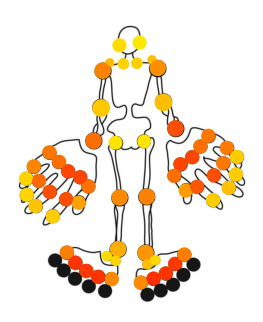

In [7]:
import matplotlib.pyplot as plt
CLUSTER =3

df_cluster = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/ClusteringIMPROVED_Complete.csv', sep=',')[['PATNR','PhenoGraph_clusters']]

CATEGORY = 'Zwelling' # 'Zwelling'
# Import mannequin information
df_man = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Metadata_complete.csv', sep='|') 
#df_cluster['PATNR']=df_cluster['pseudoId'].copy()
l_pat = set(df_cluster[df_cluster['PhenoGraph_clusters']==CLUSTER]['PATNR'])
df_sub = df_man[df_man['pseudoId'].astype(int).isin(list(l_pat))].copy()

#create scatterplot (toDo: for both big & small joints)
#l_col = [col for col in df_sub.columns if col not in ['pseudoId', 'patnr','FirstConsult', 'PATNR']]
l_mannequin = [col for col in df_man.columns if ((('Zwelling_' in col or 'Pijn_' in col)) and 'positive' in col)]
l_col = l_mannequin.copy()
#l_col = [col for col in l_mannequin if CATEGORY in col]
df_plot = pd.DataFrame(df_sub[l_col].mean().T)
df_plot= df_plot.reset_index()
df_plot.columns = ['feature', 'value']
df_plot['x'], df_plot['y'], df_plot['s'] = zip(*df_plot['feature'].apply(lambda x : func.get_mannequin_coord(x)))
df_plot['s'] = df_plot['s'] #* df_plot['value']

# Visualize gestalt
im = plt.imread('../../figures/2_processing/Mannequin_large_old.jpg')
implot = plt.imshow(im)
plt.scatter(df_plot.x, df_plot.y, s=df_plot.s, c=df_plot.value, vmin=0, vmax=1, cmap='autumn_r')
fig = plt.gcf()
fig.set_dpi(100)
#plt.text(450, 1, r'Cluster %s' % str(CLUSTER+1), fontsize=15)
plt.axis('off')

### #3.6 Visualize Learned embedding

In [ ]:
import sys
sys.path.append(r'../')
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import utils as pup
import pandas as pd
import numpy as np

df_z = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/results/embedding/IMPROVED_embedding_projections.csv', sep=',')
l_embedding = [col for col in df_z.columns]

# Variables from replication set
df_projection = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/ClusterAssignment_IMPROVED.csv', sep=',')

# import metadata of SyG replication set
metadata_rep = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/metadata_improved.csv', sep='|')
#metadata_rep = metadata_rep[metadata_rep['PATNR'].isin(l_pat_repl)].copy()
metadata_rep = metadata_rep.reset_index(drop=True)

metadata_rep['Replication'] = 1
# add cluster info for projected patietns
metadata_rep['PhenoGraph_clusters'] = df_projection['PhenoGraph_clusters'].copy() # len(metadata['PhenoGraph_clusters'].unique())+1

# import metadata of development set
metadata_RA = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270.csv', index_col=0) #  pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_metadata.csv')
metadata_RA['Replication'] = 0

# Combine both metadatas
metadata = metadata_RA.append(metadata_rep, ignore_index = True)

# Add projected patients to original set
l_latent = [col for col in l_embedding if col not in ['pseudoId', 'PATNR']]

print('BEFORE: total samples for tsne: ', len(metadata_RA))
metadata_total, z_total = pup.add_projected_patients(metadata_RA, pd.DataFrame(z_filtered, columns=l_latent), metadata_rep, z_patient[l_latent]) # ix = 
print('After: total samples for tsne: ', len(metadata_total))

In [23]:
metadata_total.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/IMPROVED_Complete_META.csv', sep=';', index=None)

#### train parametric umap

In [ ]:
from umap.parametric_umap import ParametricUMAP
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import importlib as imp


# Define the encoder model
def create_encoder(input_dim, latent_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(64, activation='sigmoid')(input_layer) # sigmoid
    x = Dense(32, activation='sigmoid')(x)
    x = Dense(16, activation='sigmoid')(x)
    latent_space = Dense(latent_dim)(x)  # No activation in the output layer

    return Model(input_layer, latent_space, name='encoder')
 
# Parameters
input_dim = 8
latent_dim = 2  # Target dimension for UMAP

encoder = create_encoder(input_dim, latent_dim)
encoder.summary()

keras_fit_kwargs = {"callbacks": [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=10**-3,
        patience=10,
        verbose=1,
    )
]}

SEED = 20240513

embedder = ParametricUMAP(random_state=SEED, keras_fit_kwargs=keras_fit_kwargs, encoder=encoder, n_training_epochs=20) #
embedding = embedder.fit_transform(z_filtered)
pup.plot_tsne(embedding, group_id=metadata_RA['PhenoGraph_clusters'], path='../../figures/7_replication/umap_original_IMPROVED.png')

# save parametric UMAP
embedder.save('../models/umap/umap_mapping_IMPROVED')

#### #3.6.2 Project both original and replication samples

In [34]:
# Project replication data onto tSNE
fit2 = embedder.transform(z_total.values)

# Plot Umap as 2d image
pup.plot_tsne(fit2, group_id=metadata_total['Replication'], path='../../figures/7_replication/umap_replication_projected_IMPROVED.png')


Product space (2D representation)            |  Newly projected patients on product space
:-------------------------:|:-------------------------:
![tsne_original]('../../figures/7_replication/umap_original_IMPROVED.png) |  ![tsne_replicate]('../../figures/7_replication/umap_replication_projected_IMPROVED.png)

In [35]:
sys.path.append(r'../../src/1_emr_scripts')
import Visualization as func
l_cat = [col for col in df_categoric_replication.columns if col not in ['PATNR','RF' , 'Age_Early', 'Age_Late']]

# update column
metadata_total['Replication'] = metadata_total['Replication'].astype(float)
metadata_total = metadata_total.fillna(0)

l_cat_spec = ['RF']
l_cat_spec.extend(l_cat)
l_cat_spec.append('Replication')
l_cat_spec.append('PATNR')
l_cat_spec.append('PhenoGraph_clusters')

# Save embedding + projection
df_z.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/results/embedding/IMPROVED_embedding_projections.csv', index=False, sep=',')

func.visualize_umap_bokeh_na_2(fit2, metadata_total[l_cat_spec],  l_cat_spec, l_binary=l_cat_spec, patient_id='PATNR', cluster_id='PhenoGraph_clusters', title='MMAE_UMAP2',  path='/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/IMPROVED_MMAE.html')

1694 1694
0 []

UMAP figure saved under location: TSNE/Baseline_MMAE_UMAP2.html


In [24]:

def calculate_DAS28(tjc, sjc, esr):
    """
    Calculate DAS28 with 3 variables : TJC, SJC and ESR (BSE)
    """
    #print(esr, tjc, sjc)
    if esr != 0.0:
        das28 = (0.56 * np.sqrt(tjc) + 0.28 * np.sqrt(sjc) + 0.70 * np.log(esr)) * 1.08 + 0.16
    else :
        das28 = np.nan
        print(esr, tjc, sjc)
    return das28

def calculate_DAS44(tjc, sjc, esr):
    """
    Calculate DAS44 with 3 variables : RAI, SJC and ESR (BSE)
    """
    if esr != 0.0:
        das44= (0.53938 * np.sqrt(tjc) + 0.0650 * (sjc) + 0.330 * np.log(esr)) + 0.224 
    else :
        das44 = np.nan
        print(esr, tjc, sjc)
    return das44

df_replication =metadata_rep.copy()
df_replication['DAS28'] = df_replication.apply(lambda x : calculate_DAS28(x['TJC'], x['SJC'], x['BSE']), axis=1)
df_replication['DAS44']  = df_replication.apply(lambda x : calculate_DAS44(x['TJC'], x['SJC'], x['BSE']), axis=1)

# Get more insight into Mannequin by visualizing the ratios
df_replication['Swollen ratio'] = df_replication['SJC'] / (df_replication['SJC']+df_replication['TJC'])
df_replication['Swollen ratio'] = df_replication['Swollen ratio'].fillna(0) 
df_replication['Tender ratio'] = df_replication['TJC'] / (df_replication['SJC']+df_replication['TJC'])
df_replication['Tender ratio'] = df_replication['Tender ratio'].fillna(0)

# Export table
df_replication.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/metadata_clusters_improved.csv', sep='|', index=None)

### Downstream analysis

### get last follow up date

In [10]:
import pandas as pd
import numpy as np

file_path = '/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Totaal overzicht ptn.sav'
# Read the Stata file into a pandas DataFrame
df = pd.read_spss(file_path)

# Convert the 'Date' columns to datetime format
date_columns = df.columns[df.columns.str.startswith('Vis')]

def convert_to_datetime(date_string):
    try:
        return pd.to_datetime(date_string)
    except ValueError:
        return np.nan

df[date_columns] = df[date_columns].applymap(convert_to_datetime)


# Find the largest date per row
df['LastDate'] = df[date_columns].max(axis=1)

date_columns = list(date_columns)
date_columns.extend(['IDNUM', 'LastDate'])
d_lastdate = dict(zip(df['IDNUM'], df['LastDate']))

In [ ]:
def getDate(d, m, y):
    date = ''
    if d == 0 :
        d =1 # days start counting from 1
    if d == d and m == m and y == y:
        if len(str(int(d))) < 2:
            date += '0' 
        date += str(int(d)) + '-'
        if len(str(int(m))) < 2:
            date += '0' 
        date += str(int(m)) + '-'
        date += str(int(y))
        if y > 2030:
            print('Impossible Date found (added np.nan):', date)
            return np.nan
        if d > 31:
            print('Impossible Date found (added np.nan):', date)
            return np.nan
        if m > 12:
            print('Impossible Date found (added np.nan):', date)
            return np.nan
        else :
            return date
    else : 
        return np.nan
file_path = '/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/FollwUp visite 2-4.SAV'

# Read the Stata file into a pandas DataFrame
df_visitdat = pd.read_spss(file_path)

df_visitdat['visitDate'] = df_visitdat.apply(lambda x : getDate(x['EVALDATD'], x['EVALDATM'], x['EVALDATY']), axis =1 )
df_visitdat['visitDate'] = pd.to_datetime(df_visitdat['visitDate'], format='%d-%m-%Y')

df_longterm['pt_visit'] = df_longterm['IDNUM'].astype(str) + '_' + df_longterm['visit'].astype(str)
df_visitdat['pt_visit'] = df_visitdat['IDNUM'].astype(int).astype(float).astype(str) + '_' + df_visitdat['EVALNUM'].astype(int).astype(str)
d_dates_avail= dict(zip(df_visitdat['pt_visit'], df_visitdat['visitDate']))

df_longterm['Datum visit'] = df_longterm['pt_visit'].apply(lambda x : d_dates_avail[x] if x in d_dates_avail.keys() else np.nan)
df_dates = df_longterm[['IDNUM', 'visit', 'pt_visit', 'Datum visit']]

df_followup = df_dates.sort_values(by='Datum visit', ascending=False).drop_duplicates(subset=['IDNUM'])
d_alt_last = dict(zip(df_followup['IDNUM'], df_followup['Datum visit']))
#df_followup
d_alt_last

d_dates = dict(zip(df_dates['pt_visit'], df_dates['Datum visit'])) # TIME_STA
df_dates                 

In [ ]:
l_col_rem = [col for col in df_longterm.columns if 'Remissie_' in col]
l_rem = [col for col in df_replication.columns if 'Remissie_' in col]

l_rem.extend(['PATNR', 'PhenoGraph_clusters', 'FirstConsult', 'Sex', 'Age', 'aCCP', 'BSE', 'RF', 'TJC', 'SJC', 'symptomDuration', 'ImmuneDiversity'])

df_remission = df_replication[l_rem].copy()

# Add ind
df_rem_wide = pd.DataFrame(columns = l_col_rem) #l_col_rem
for i, col in enumerate(l_col_rem): 
    df_rem_wide[col] = pd.Series(df_longterm[df_longterm['visit']==i+1][col].reset_index(drop=True))

df_remission = df_remission.merge(df_rem_wide, left_index=True, right_index=True)

df_replication = df_replication.reset_index(drop=True)



# create dummy variables
just_dummies = pd.get_dummies(df_remission['PhenoGraph_clusters']) # PhenoGraph_clusters
df_remission = pd.concat([df_remission, just_dummies], axis=1)   
df_remission = df_remission.rename(columns={0: 'Cluster1', 1: 'Cluster2', 2: 'Cluster3', 3: 'Cluster4', 4: 'Cluster5',5: 'Cluster6'})



df_remission

In [ ]:
import re
l_col_rem = [col for col in df_remission.columns if 'Remissie_' in col]


rms = df_remission[l_col_rem].eq(1, axis=1)
df_remission['Remission'] = rms.dot(rms.columns + ', ').str.split(',')
df_remission['firstVisit'] = pd.to_datetime(df_remission['FirstConsult'], format='%Y-%m-%d')

#numeric_values = re.findall(r'\b\d+\.\d+|\d+\b', text)

def func_rem(x):
    #print(x)
    if x != [''] :
        #print(x[0], re.findall(r'V(\d+)', x[0]))
        return re.findall(r'V(\d+)', x[0])[0] 
    else :
        return np.nan

df_remission['visit_Rem'] = df_remission['Remission'].apply(lambda x : func_rem(x))
df_remission['pt_visit'] =df_remission['PATNR'].astype(float).astype(str) + '_' + df_remission['visit_Rem'].astype(str)
df_remission['time_Rem'] = df_remission['pt_visit'].apply(lambda x : d_dates[x] if str(x) in d_dates.keys() else np.nan)

df_remission['time_Rem'] = pd.to_datetime(df_remission['time_Rem'], format='%Y-%m-%d')
df_remission['time_till_Rem'] = df_remission['time_Rem'] -  df_remission['firstVisit'] 
df_remission['time_till_Rem'] = df_remission['time_till_Rem'].dt.days

df_remission['lastVisit'] = df_remission['PATNR'].apply(lambda x: d_lastdate[x])
df_remission['lastVisit'] = df_remission['lastVisit'].fillna(df_remission['PATNR'].apply(lambda x : d_alt_last[x]))
df_remission['lastVisit'] = pd.to_datetime(df_remission['lastVisit'], format='%Y-%m-%d')

df_remission['followUp'] = df_remission['lastVisit'] -  df_remission['firstVisit'] 
df_remission['followUp'] = df_remission['followUp'].dt.days

df_remission['event_Rem'] = (~ df_remission['time_till_Rem'].isna()).astype(int)
df_remission['event_1y_Rem'] = (df_remission['time_till_Rem'] < 366).astype(int)
df_remission['time_till_Rem']= df_remission['time_till_Rem'].fillna(df_remission['followUp'])

# create dummy variables
df_subBEST = df_remission.copy()
df_subBEST['Cluster'] = df_subBEST['PhenoGraph_clusters'] + 1

df_subBEST['patnr'] = df_subBEST['PATNR'].copy()#.str[:9]

# Drop patients with missing follow up info
#df_subBEST = df_subBEST[~df_subBEST['time_till_Rem'].isna()].reset_index(drop=True)

# Calculate DAS44
def calculate_DAS44(tjc, sjc, esr):
    """
    Calculate DAS44 with 3 variables : RAI, SJC and ESR (BSE)
    """

    das44= (0.53938 * np.sqrt(tjc) + 0.0650 * (sjc) + 0.330 * np.log(esr)) + 0.224 #0.224
    return das44

df_subBEST['DAS44'] = df_subBEST.apply(lambda x : calculate_DAS44(x['SJC'], x['TJC'], x['BSE']), axis=1)

# export survival data 
# [df_subBEST['Cluster'].isin([3,4])]
df_subBEST[['patnr', 'time_till_Rem', 'event_1y_Rem', 'event_Rem', 'Cluster',  'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'aCCP', 'DAS44', 'symptomDuration', 'ImmuneDiversity']].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/df_survivaldata_improved_Remission.csv')

# export for prediction model

df_subBEST[['patnr', 'time_till_Rem', 'event_Rem', 'event_1y_Rem', 'FirstConsult', 'followUp', 'Cluster', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'aCCP', 'RF', 'SJC', 'TJC', 'BSE', 'symptomDuration', 'ImmuneDiversity']].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/df_improved_REMISSION_visnr.csv', sep='|', index=False)

In [75]:
df_subBEST[['patnr', 'time_till_Rem', 'event_Rem', 'event_1y_Rem','followUp', 'Cluster', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'aCCP', 'RF', 'SJC', 'TJC', 'BSE']].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/df_improved_REMISSION_visnr.csv', sep='|', index=False)

## 4.1 Treatment response 

In [ ]:
import pandas as pd
df_subBEST = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/df_survivaldata_improved_Remission.csv', sep=',')

In [ ]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)

FOLLOWUP= 365 

pal_colorblind = ['#4F6CCF', '#2db9cc', '#fcba03', '#FA4D4D',   "#7a4da4", "#a67c73", "#FF0000FF", "#CCFF00FF", "#49BA2B", "#0066FFFF", "#CC00FFFF", '#FF9595'];

kmf = KaplanMeierFitter()

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)
ix = 0

# Set y-axis limits
plt.ylim(0, 1)

for name, grouped_df in df_subBEST.groupby('Cluster'):
    kmf.fit(grouped_df["time_till_Rem"], grouped_df["event_1y_Rem"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    kmf.plot_survival_function(ax=ax, color=pal_colorblind[ix])
    print(grouped_df["time_till_Rem"].max())

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Without remission (%)')
    ax.set_ylim([0, 1])

    df = kmf.event_table.copy()
    df = df.reset_index()
    
    # calculate final patients that stay with baseline by hand (positive control)
    print('Patients that reach remission in cluster %s: %.3f' % (name, 1 - kmf.survival_function_.iloc[-1].values[0]),  round(kmf.survival_function_.iloc[-1].values[0]*len(df_subBEST[((df_subBEST['time_till_Rem']>=0) & (df_subBEST['Cluster']==name) )]))) # (df_response['time']>=0) &
    ix +=1 
    

### acpa effect in improved study

Patients that stay with treatment in cluster (1.0, 0.0): 0.281 0
No of patients: 27
Patients that stay with treatment in cluster (1.0, 1.0): 0.345 0
No of patients: 61
Patients that stay with treatment in cluster (2.0, 0.0): 0.279 0
No of patients: 27
Patients that stay with treatment in cluster (2.0, 1.0): 0.257 0
No of patients: 69
Patients that stay with treatment in cluster (3.0, 0.0): 0.286 0
No of patients: 21
Patients that stay with treatment in cluster (3.0, 1.0): 0.244 0
No of patients: 27
Patients that stay with treatment in cluster (4.0, 0.0): 0.549 0
No of patients: 26
Patients that stay with treatment in cluster (4.0, 1.0): 0.575 0
No of patients: 37


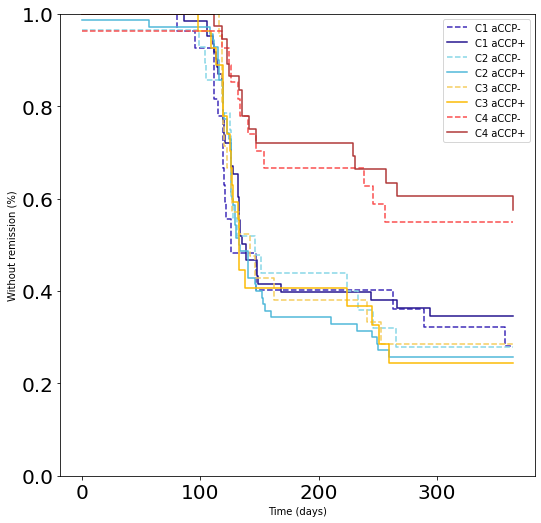

In [9]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
import seaborn as sns
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)


FOLLOWUP= 365 

kmf = KaplanMeierFitter()

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)

# Set y-axis limits
plt.ylim(0, 1)  # Adjust the values as needed
l_pal = ['#3d2ab8', '#24148f', '#87d6e6', '#4eb8d9',  '#f5cd5f', '#fcba03', '#FA4D4D', '#b03737',] # ['#77b4d4', '#1f78b4', '#f7aa45', '#ff7f00', '#79bd3c',  '#33a02c', '#f07271', '#e31a1c']

l_acpa_neg_c3 = []

i = 0
for name, grouped_df in df_subBEST.groupby(['Cluster', 'aCCP']):
    kmf.fit(grouped_df["time_till_Rem"], grouped_df["event_Rem"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    
    if i % 2 == 0:
        linestyle='dashed' 
    else :
        linestyle='solid'
    
    kmf.plot_survival_function(ax=ax, color = l_pal[i], ci_show=False, linestyle=linestyle) # 
    #print(grouped_df["time_till_Rem"].max())
   

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Without remission (%)')

    df = kmf.event_table.copy()
    df = df.reset_index()
    #print('balblble', str(name[0]), str(kmf.survival_function_.iloc[-1].values[0]))
    
    if name[0] == 3 and name[1] == 0 : 
        l_acpa_neg_c3 = list(grouped_df[grouped_df["time_till_Rem"]>0]['patnr'])
    # calculate final patients that stay with baseline by hand (positive control)
    print('Patients that stay with treatment in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_subBEST[((df_subBEST['time_till_Rem']>=0) & (df_subBEST['Cluster']==name) )]))) # (df_response['time']>=0) &
    print('No of patients:', len(grouped_df[grouped_df["time_till_Rem"]>0]))
    i += 1
    
# call method plt.legend
plt.legend(['C1 aCCP-', 'C1 aCCP+', 'C2 aCCP-', 'C2 aCCP+', 'C3 aCCP-', 'C3 aCCP+', 'C4 aCCP-', 'C4 aCCP+'])

1874.0
Patients that stay without remission in cluster 0.0: 0.352 0
4315.0
Patients that stay without remission in cluster 1.0: 0.342 30


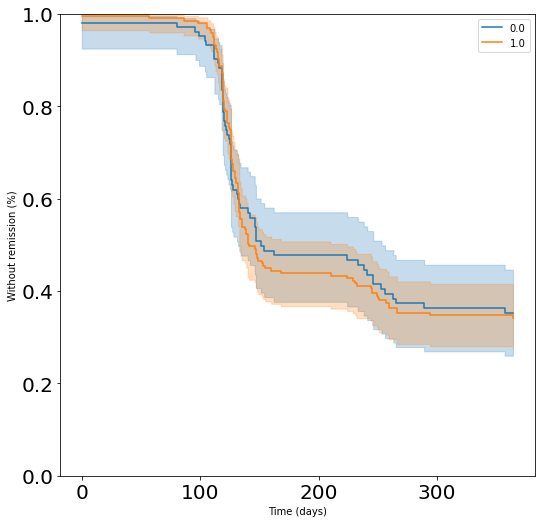

In [10]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)

FOLLOWUP= 365 

kmf = KaplanMeierFitter() # , timeline=range(1, FOLLOWUP, 1)

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)
plt.ylim(0, 1)
ix = 0

for name, grouped_df in df_subBEST.groupby('aCCP'):
    kmf.fit(grouped_df["time_till_Rem"], grouped_df["event_Rem"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    kmf.plot_survival_function(ax=ax)
    print(grouped_df["time_till_Rem"].max())

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Without remission (%)')

    df = kmf.event_table.copy()
    df = df.reset_index()
    
    # calculate final patients that stay with baseline by hand (positive control)
    print('Patients that stay without remission in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_subBEST[((df_subBEST['time_till_Rem']>=0) & (df_subBEST['Cluster']==name) )]))) 
    ix+=1

In [11]:
from lifelines import CoxPHFitter
import itertools

FOLLOWUP = 365
EVENT = 'event_1y_Rem'
N_CLUSTERS = 4
print('Follow up :', FOLLOWUP)
print('Alpha (after Bonferroni):', round(0.05/len(list(itertools.combinations(range(1,N_CLUSTERS+1), 2))), 5 ))



i = 1
for x in itertools.combinations(range(1,N_CLUSTERS+1), 2) :
    #print(cluster)
    l_cluster = [x[0], x[1]]
    cph = CoxPHFitter()
    cph.fit(df_subBEST[((df_subBEST['Cluster'].isin(l_cluster)) & (df_subBEST['aCCP']==0))][['time_till_Rem', EVENT, 'Cluster%s' % (l_cluster[0])]], duration_col='time_till_Rem', event_col=EVENT )

    p_val = cph.summary['p'].values[0]
    #print(p_val)
    effect = cph.summary['exp(coef)'].values[0]
    ci_lower = cph.summary['exp(coef) lower 95%'].values[0]
    ci_upper = cph.summary['exp(coef) upper 95%'].values[0]
    
    p_val = p_val #/ len(list(itertools.combinations(range(1,7), 2))) # Conservative Bonferroni Multiple testing correction
    print('Clusters %s-%s : HR:%s (%s-%s) p-val=%s ' % (x[0], x[1], round(effect,2), round(ci_lower,2), round(ci_upper,2), round(p_val,10)))
    i = i + 1 

Follow up : 365
Alpha (after Bonferroni): 0.00833
Clusters 1-2 : HR:1.1 (0.58-2.08) p-val=0.771929803 
Clusters 1-3 : HR:1.09 (0.55-2.15) p-val=0.7981129351 
Clusters 1-4 : HR:2.29 (1.11-4.74) p-val=0.0252788517 
Clusters 2-3 : HR:0.99 (0.5-1.95) p-val=0.9825266398 
Clusters 2-4 : HR:2.21 (1.07-4.57) p-val=0.032803982 
Clusters 3-4 : HR:2.21 (1.03-4.73) p-val=0.0417646633 


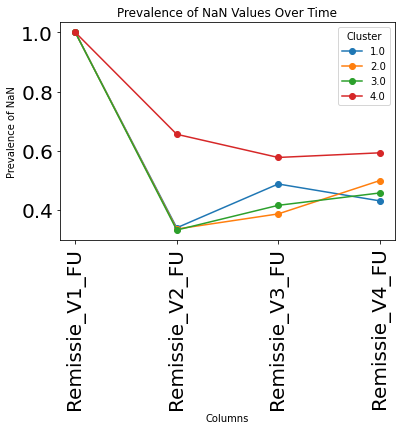

In [16]:
import matplotlib.pyplot as plt
grouped = df_subBEST.groupby('Cluster')[['Remissie_V1_FU', 'Remissie_V2_FU', 'Remissie_V3_FU', 'Remissie_V4_FU']]

nan_prevalence = grouped.apply(lambda x: x.isna().mean())

# Transpose the DataFrame to have columns as groups and rows as columns
nan_prevalence = nan_prevalence.T

# Plot the line plot
nan_prevalence.plot(kind='line', marker='o')

# Set plot title and axes labels
plt.title('Prevalence of NaN Values Over Time')
plt.xlabel('Columns')
plt.xticks(rotation=90)
plt.ylabel('Prevalence of NaN')

# Show the plot
plt.show()

### Get delta time difference

In [13]:
import numpy as np
import pandas as pd

# Replace 'your_file.dta' with the actual file path
#file_path = '/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Inclusie_basisdocument.SAV'
file_path = '/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Basis werkbestand 5 jaar LONG.dta'
# file_path = '/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/IMPROVED/Copy of FollwUp-volledig opgeschoond V2-4.dta'

# Read the Stata file into a pandas DataFrame
df = pd.read_stata(file_path)


d_map = {
    'IDNUM' : 'PATNR',
    
}
df = df.rename(columns= d_map)
df['PATNR'] = df['PATNR'].astype(int)

# Keep track of last DAS
df_last_das = df[df['visit'].isin([1,2,3,4])].sort_values(by='visit',ascending=False).dropna(subset=['DASV']).drop_duplicates(subset=['PATNR'])
d_last_das = dict(zip(df_last_das['PATNR'], df_last_das['DASV']))

In [ ]:
df_replication['last_DAS44'] = df_replication['PATNR'].apply(lambda x : d_last_das[x] if x in d_last_das.keys() else np.nan)

df_replication[['PATNR','DAS44', 'last_DAS44', 'PhenoGraph_clusters']]

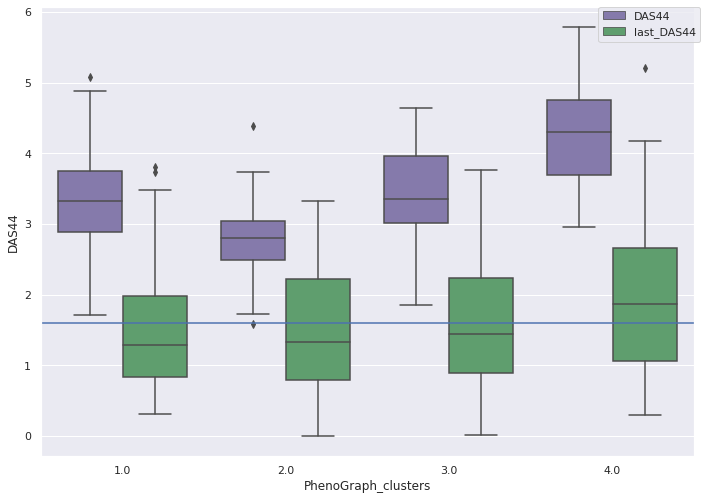

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot
a4_dims = (11.7, 8.27)
sns.set() 
fig, ax = plt.subplots(figsize=a4_dims)

# df_response['DAS_delta']= abs(df_response['DAS28'] - df_response['FinalDAS28'])
df_plot = pd.melt(df_replication[['DAS44', 'last_DAS44', 'PATNR']], id_vars=['PATNR'], value_vars=['DAS44', 'last_DAS44'])
df_plot = df_plot.merge(df_replication[[ 'PATNR', 'PhenoGraph_clusters']],left_on='PATNR', right_on='PATNR')
df_plot['PhenoGraph_clusters'] = df_plot['PhenoGraph_clusters'] + 1
sns.boxplot(x='PhenoGraph_clusters', y='value', #z = 'FinalDAS28',
             palette=["m", "g"], hue='variable',
            data=df_plot) # hue='Treatment_shift',
plt.ylabel('DAS44')
plt.axhline(1.6)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

# MTX response

In [91]:
import pandas as pd 
import numpy as np


df_replication = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/BaselinePopulation_REPLICATION_IMPROVED.csv', sep=';') 
print('Nr of pts:', len(df_replication))
d_das44 = dict(zip(df_replication['PATNR'], df_replication['DAS44']))
d_indeling = dict(zip(df_replication['PATNR'], df_replication['INDELINGIMPROVED']))
d_initial = {'early remission' : 1,'arm 2' : 0, 'arm 1' : 0, 'violation': np.nan} # Violation wel of niet mee?

df_subBEST['Group'] = df_subBEST['patnr'].apply(lambda x : d_indeling[x])
df_subBEST['on_INITIAL_MTX'] = df_subBEST['Group'].apply(lambda x : abs(d_initial[x]-1))
df_subBEST['DAS44'] = df_subBEST['patnr'].apply(lambda x : d_das44[x])
df_subBEST['Cluster3'] = df_subBEST['Cluster']==3
print('Nr of pts:', len(df_subBEST), '\t\tNr of pts without violation:', len(df_subBEST[df_subBEST['Group']!='violation']))
df_subBEST_CCP = df_subBEST.copy()#[( (df_subBEST['Cluster'].isin([4,3]))) ].copy() # & (df_subBEST['aCCP']==1))

cross_tab = pd.crosstab(index=df_subBEST_CCP['Cluster'], columns=df_subBEST_CCP['on_INITIAL_MTX'], normalize='index')
raw_cross_tab = pd.crosstab(index=df_subBEST_CCP['Cluster'], columns=df_subBEST_CCP['on_INITIAL_MTX'])
#print(cross_tab)
#

Nr of pts: 307
Nr of pts: 234 		Nr of pts without violation: 215


In [88]:
import pandas as pd 
import numpy as np


df_replication = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/BaselinePopulation_REPLICATION_IMPROVED.csv', sep=';') 
for clust in df_replication['PhenoGraph_clusters'].unique():
    print('aCARP', clust, df_replication[df_replication['PhenoGraph_clusters']==clust]['aCarP'].mean())

aCARP 2.0 0.4
aCARP 1.0 0.4946236559139785
aCARP 0.0 0.4225352112676056
aCARP 3.0 0.2833333333333333


### Adjust for symptomDuration

In [89]:
import pandas as pd
import statsmodels.api as sm


df_subBEST_CCP = df_subBEST[( (df_subBEST['Cluster'].isin([3, 1])))].copy() # 
# Example data
data = {
    'event_1y': np.array(df_subBEST_CCP['on_INITIAL_MTX']), # on initial mtx should be within a year
    'Cluster3': np.array(df_subBEST_CCP['Cluster3']),
    'DAS44': np.array(df_subBEST_CCP['DAS44']),  # Covariate
    'symptomDuration': np.array(df_subBEST_CCP['symptomDuration'])  # Covariate
}

df = pd.DataFrame(data)

# Fit logistic regression model
model1 = sm.Logit.from_formula('event_1y ~ symptomDuration', data=df)
result1 = model1.fit()

# Print summary of results
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.568917
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               event_1y   No. Observations:                  106
Model:                          Logit   Df Residuals:                      104
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                 0.01461
Time:                        16:04:31   Log-Likelihood:                -60.305
converged:                       True   LL-Null:                       -61.200
Covariance Type:            nonrobust   LLR p-value:                    0.1811
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.3672      0.346     -3.952      0.000      -2.045      -0.689
symptomDuratio

In [126]:
df_setA = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_survivaldata_mmae.csv')
df_setA[((df_setA['Cluster'].isin([3, 4])))].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_survivaldata_mmae_sub.csv')
#df_subBEST_CCP = df_setA.copy()

In [124]:
import pandas as pd
import statsmodels.api as sm


df_subBEST_CCP = df_setA[( (df_setA['Cluster'].isin([3, 1])))].copy() # 
# Example data
data = {
    'event_1y': np.array(df_subBEST_CCP['event_1y'].astype(int)), # on initial mtx should be within a year
    'Cluster3': np.array(df_subBEST_CCP['Cluster3']),
    'DAS44': np.array(df_subBEST_CCP['DAS44']),  # Covariate
    'symptomDuration': np.array(df_subBEST_CCP['symptomDuration'])  # Covariate
}

df = pd.DataFrame(data)

# Fit logistic regression model
model1 = sm.Logit.from_formula('event_1y ~ symptomDuration + Cluster3', data=df)
result1 = model1.fit()

# Print summary of results
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.516591
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               event_1y   No. Observations:                  339
Model:                          Logit   Df Residuals:                      336
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Jul 2024   Pseudo R-squ.:                 0.02925
Time:                        17:01:41   Log-Likelihood:                -175.12
converged:                       True   LL-Null:                       -180.40
Covariance Type:            nonrobust   LLR p-value:                  0.005105
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.9797      0.163     -6.024      0.000      -1.298      -0.661
symptomDuratio

### Check if still significant in ACPA pos stratum if adjust for baseline DAS
We use logistic regression for this purpose

In [106]:
from scipy.stats import chi2_contingency
import statsmodels.api as sm
# Perform chi-square test of independence
from statsmodels.stats.contingency_tables import Table2x2

chi2, p_value, dof, expected = chi2_contingency(raw_cross_tab)

print("Chi-square statistic:", chi2)
print("P-value:", p_value)

# Calculate odds ratio
# Calculate odds ratio and confidence intervals

# Calculate odds ratio and confidence intervals
table = Table2x2(raw_cross_tab.values)
odds_ratio = table.oddsratio
ci_low, ci_high = table.oddsratio_confint()


print("Odds ratio:", odds_ratio)
print("95% Confidence interval:", (ci_low, ci_high))

Chi-square statistic: 8.37847500763514
P-value: 0.003796908784615546
Odds ratio: 3.6387959866220734
95% Confidence interval: (1.5803693383143598, 8.378317594025042)


In [31]:
import pandas as pd
import statsmodels.api as sm

# Example data
data = {
    'event_1y': np.array(df_subBEST_CCP['on_INITIAL_MTX']),
    'Cluster3': np.array(df_subBEST_CCP['Cluster3']),
    'DAS44': np.array(df_subBEST_CCP['DAS44'])  # Covariate
}

df = pd.DataFrame(data)

# Fit logistic regression model
model1 = sm.Logit.from_formula('event_1y ~ Cluster3 + DAS44', data=df)
result1 = model1.fit()

# Print summary of results
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.641880
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               event_1y   No. Observations:                  102
Model:                          Logit   Df Residuals:                       99
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Jul 2024   Pseudo R-squ.:                 0.06983
Time:                        15:40:47   Log-Likelihood:                -65.472
converged:                       True   LL-Null:                       -70.387
Covariance Type:            nonrobust   LLR p-value:                  0.007334
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4408      0.363      1.215      0.224      -0.270       1.152
Cluster3[T.

In [188]:
# Example data
data = {
    'event_1y': np.array(df_subBEST_CCP['on_INITIAL_MTX']),
    'DAS44': np.array(df_subBEST_CCP['DAS44'])  # Covariate
}
df2 = pd.DataFrame(data)

# Fit logistic regression model
model2 = sm.Logit.from_formula('event_1y ~ DAS44', data=df2)
result2 = model2.fit()

# Print summary of results
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.565244
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               event_1y   No. Observations:                   83
Model:                          Logit   Df Residuals:                       81
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Apr 2024   Pseudo R-squ.:               0.0006656
Time:                        17:36:20   Log-Likelihood:                -46.915
converged:                       True   LL-Null:                       -46.946
Covariance Type:            nonrobust   LLR p-value:                    0.8026
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4252      1.399     -1.019      0.308      -4.167       1.317
DAS44          0.1070      0.